In [1]:
import os
import time
import json

# from utils.file_utils import *
from datasets import list_datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from IPython import get_ipython
import pandas as pd
from tqdm import tqdm
from MergeModel import *
from ClassifierModel import *
import matplotlib.pyplot as plt

get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', 2)

#### Bart tokenizer

In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartForSequenceClassification

In [3]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

In [4]:
vocab_size = tokenizer.vocab_size
vocab_size

50265

### Classifier data

In [5]:
# from datasets import load_dataset

In [6]:
# dataset = load_dataset("imdb")

In [7]:
# train_batch = dataset['train']['text']
# train_labels = torch.tensor(dataset['train']['label'])

In [8]:
# train_batch = train_batch[:100]
# train_labels = torch.tensor(train_labels[:100])

In [9]:
# val_batch = dataset['test']['text']
# val_labels = torch.tensor(dataset['test']['label'])

In [10]:
# val_batch = val_batch[:100]
# val_labels = torch.tensor(val_labels[:100])

In [11]:
# seq_length = 150
# input_encoding = tokenizer(train_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [12]:
# val_encoding = tokenizer(val_batch, return_tensors='pt', padding=True, truncation = True, max_length=seq_length)

In [13]:
# input_ids = input_encoding['input_ids']
# input_mask = input_encoding['attention_mask']

In [14]:
# val_ids = val_encoding['input_ids']
# val_mask = val_encoding['attention_mask']

In [15]:
# input_ids.shape, input_mask.shape, val_ids.shape, val_mask.shape

In [16]:
# # Creating DataLoaders

# from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# # TRAINNG DATALOADER
# batch_size = 27

# train_data = TensorDataset(input_ids, input_mask, train_labels)
# train_sampler = RandomSampler(train_data)
# train_dataloader_clf = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [17]:
# # VALIDATION DATALOADER

# val_data = TensorDataset(val_ids, val_mask, val_labels)
# val_sampler = RandomSampler(val_data)
# val_dataloader_clf = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [18]:
# b = next(iter(train_dataloader_clf))

In [19]:
# b[0].shape, b[1].shape, b[2].shape

##### end

#### BART Data

In [20]:
df = pd.read_csv("../dataset/test.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 11,490



,article,highlights,id
252,(CNN)The overturned convertible was smoldering...,The overturned car was smoldering on a New Jer...,3819256c0349e40b34b23f9e9b040799629e778c
10646,"'My, my! At Waterloo Napoleon did surrender,’ ...","Contrary to the Abba song, Napoleon did not s...",eb30c7ef447aa8e41b9d438e5fd615e43bcc48fa
8041,Liverpool manager Brendan Rodgers had his conv...,Brendan Rodgers was found guilty in his absenc...,aa8ef2de0b4316d40b5cea661da4c43aa67f98df
1996,"It took a team of firefighters, police and eng...",A Narrabeen house damaged in the Sydney storms...,1594ba1779a14fc5e9024f47954e876c9a54088b
2418,"What the hell am I doing, I ask myself, as I s...",Sarah Foot began swimming outside after a dip ...,201e23126e1529feacf1c1954fee6ad184797645
6694,A pregnant Popeyes employee in Texas says that...,"Marissa Holcomb was held up in Channelview, Te...",893233c8fe83f64b0711f8aad5d4ffbae6617f29
2572,Mauricio Pochettino insists Aston Villa manage...,Tottenham Hotspur manager expects a good recep...,244dc889d4e734430dab1d6d1804b9a30be93abf
5423,A first-of-its-kind 3D simulation has revealed...,University of Illinois scientists create first...,68b31f4a39dddb8e19cc8bf770fc1eae72bec17d
8003,Father Hamish Baillie (pictured) claims Lord J...,Hamish Baillie says Lord Janner abused him dur...,a944e8f85f943e02db2d059e0bf672bacd9f40d9
5992,English essential: This laminated document ann...,ISIS has announced that all nurses working for...,76e0aa30e7033a161a11ce7c4692822772f63ade


In [21]:
train_sentence = df.article.values
train_target = df.highlights.values

In [22]:
num_data_points = 10000
train_sentence = list(train_sentence[:num_data_points])
train_target = list(train_target[:num_data_points])

In [23]:
article_encoding = tokenizer(train_sentence, return_tensors='pt', padding=True, truncation = True, max_length=500)
summary_encoding = tokenizer(train_target, return_tensors='pt', padding=True,truncation = True, max_length=100)

In [24]:
article_input_ids = article_encoding['input_ids']
article_attention_mask = article_encoding['attention_mask']

In [25]:
summary_input_ids = summary_encoding['input_ids']
summary_attention_mask = summary_encoding['attention_mask']

In [26]:
print(article_input_ids.shape, article_attention_mask.shape)

torch.Size([10000, 500]) torch.Size([10000, 500])


In [27]:
print(summary_input_ids.shape, summary_attention_mask.shape)

torch.Size([10000, 100]) torch.Size([10000, 100])


In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [29]:
batch_size = 6
train_data = TensorDataset(article_input_ids, article_attention_mask,\
                           summary_input_ids, summary_attention_mask)

In [30]:
train_sampler = RandomSampler(train_data)

In [31]:
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [32]:
def loss_fn(lm_logits, labels):
    loss_fct = CrossEntropyLoss(ignore_index = tokenizer.pad_token_id)
    loss = loss_fct(lm_logits.view(-1, vocab_size), labels.view(-1))
    return loss

In [33]:
mse_loss = nn.MSELoss()

In [34]:
sent_model = ClassifierModel(vocab_size, 64, 2, 2, 512).cuda()

sent_model.load_state_dict(torch.load('classifier_model.pt'))

<All keys matched successfully>

In [35]:
for params in sent_model.parameters():
    params.requires_grad = False

In [36]:
summary_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

In [37]:
summary_model = summary_model.cuda()
senti_model = sent_model.cuda()

In [38]:
# embedding_dim = 64
# out_dim = 2
# n_layers = 4
# hidden_size = 512
merge_model = MergeModel(summary_model, senti_model).cuda()
model_name = 'BART_classifier'
model_dir = './experiment'
model_path = os.path.join(model_dir,model_name)
epochs  = 50

In [39]:
for params in merge_model.sentiment_model.parameters():
    params.requires_grad = False

In [40]:
config = {
#     'embedding_dim': embedding_dim,
#     'out_dim': out_dim,
#     'n_layers': n_layers,
#     'hidden_size': hidden_size,
    'model_name': model_name,
    'epochs':epochs
}

In [41]:
# Apply the weighting lambdas in the main function this is just a loss without lambda weights
def kl_div_loss(p_pred, p_target):
    
    softmax = nn.Softmax(dim=-1)
    
    logsoftmax = nn.LogSoftmax(dim=-1)
    
    kl_div = torch.nn.KLDivLoss()
    
    return kl_div(logsoftmax(p_pred),softmax(p_target))

In [42]:
softmax = nn.Softmax(dim=-1)
cross_entropy = torch.nn.CrossEntropyLoss()

In [43]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False, model_dir='/experiment',config = None):
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    min_val_loss = np.inf
    
    model_name = config['model_name']
    print(f"Start training for Model {model_name}...\n")
    
    
#     if not os.path.exists(os.path.join(model_dir,model_name)):
#         os.mkdir(os.path.join(model_dir,model_name))
#     model_path = os.path.join(model_dir,model_name)
#     print(model_path)
#     write_to_file_in_dir(model_path, 'config.json', config)
    
#     train_log =  'train_log.txt'
#     write_string_train = f"Epoch, Train_Loss, Train_Acc"
#     log_to_file_in_dir(model_path, train_log, write_string_train)

#     if evaluation:
#         val_log = 'val_log.txt'
#         write_string_val = f"Epoch, Val_Loss, Val_Acc"
#         log_to_file_in_dir(model_path, val_log, write_string_val)
    
    from transformers import AdamW
    bart_optimizer = AdamW(model.parameters(), lr=1e-5)
    
    sentiment_optimizer = torch.optim.SGD(model.parameters(),1e-5,momentum=0.9,weight_decay=0.01)
    
    for epoch_i in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Loss 1':^12} | {'Loss 2':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)
        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_loss1, batch_loss2, batch_counts = 0, 0, 0, 0, 0
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            model.train()
            batch_counts +=1
            
            batch[0] = batch[0].cuda()
            batch[1] = batch[1].cuda()
            batch[2] = batch[2].cuda()
            batch[3] = batch[3].cuda()
            
            bart_optimizer.zero_grad()
            sentiment_optimizer.zero_grad()
            
            summary_out,*sentiments = model(batch[0],batch[1], batch[2], batch[3])
        
            cost1, cost2 = 2, 1e-1
            
            loss1 = cost1*loss_fn(summary_out.logits, batch[2])

            
            loss2 = cost2*kl_div_loss(sentiments[0], sentiments[1])
            # loss2 = cost2*mse_loss(softmax(sentiments[0]), softmax(sentiments[1]))
            

            loss = loss1 + cost2 * loss2
            
            batch_loss += loss.item()
            
            batch_loss1 += loss1.item()
            
            batch_loss2 += loss2.item()
            
            total_loss += loss.item()
            
            train_losses.append(loss.item())
            
#             print(torch.autograd.grad(loss2, merge_model.summary_model.parameters(),retain_graph = True)[0])

#             write_string_train = f"{epoch_i}, {loss.item()}"
#             log_to_file_in_dir(model_path, train_log, write_string_train)
            
            
            loss1.backward(retain_graph = True)
            
            loss2.backward()
            
            bart_optimizer.step()
            
            sentiment_optimizer.step()
            
            if (step % 10 == 0) and (step != 0):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_loss1 / batch_counts:^12.6f} | {batch_loss2 / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_loss1, batch_loss2, batch_counts = 0, 0, 0, 0
                t0_batch = time.time()
                
                print("-"*70)


        
        if ((epoch_i %5 ==0) and (epoch_i != 0)) or (epoch_i==epochs-1):
            
            print([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_out.logits.argmax(dim = -1)])
        
        if ((epoch_i % 25 ==0) and (epoch_i != 0)) or (epoch_i==epochs-1):
            torch.save(model.state_dict(), f'BART_classifier_{epoch_i}_KL.pt')
            
        
    torch.save(model.state_dict(), 'BART_classifier_final_KL.pt')
        
    return  train_losses, train_accs, val_losses,val_accs

In [44]:
stats = train(merge_model, train_dataloader, val_dataloader=None, epochs=epochs, evaluation=False,  config=config)

Start training for Model BART_classifier...

 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1932: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


   1    |   10    |   6.929928   |   6.929831   |   0.000967   |     -      |     -     |   5.94   
----------------------------------------------------------------------
   1    |   20    |   6.195002   |   6.194919   |   0.000828   |     -      |     -     |   5.26   
----------------------------------------------------------------------
   1    |   30    |   6.220813   |   6.220736   |   0.000772   |     -      |     -     |   5.26   
----------------------------------------------------------------------
   1    |   40    |   5.889481   |   5.889408   |   0.000725   |     -      |     -     |   5.28   
----------------------------------------------------------------------
   1    |   50    |   5.446449   |   5.446367   |   0.000821   |     -      |     -     |   5.37   
----------------------------------------------------------------------
   1    |   60    |   5.668200   |   5.668134   |   0.000657   |     -      |     -     |   5.29   
---------------------------------------------

   1    |   490   |   4.826602   |   4.826556   |   0.000460   |     -      |     -     |   5.54   
----------------------------------------------------------------------
   1    |   500   |   5.089972   |   5.089922   |   0.000494   |     -      |     -     |   5.38   
----------------------------------------------------------------------
   1    |   510   |   4.359229   |   4.359179   |   0.000501   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   1    |   520   |   4.233942   |   4.233893   |   0.000493   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   1    |   530   |   4.334353   |   4.334310   |   0.000424   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   1    |   540   |   4.932289   |   4.932239   |   0.000498   |     -      |     -     |   5.47   
---------------------------------------------

   1    |   970   |   4.744041   |   4.743995   |   0.000455   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   1    |   980   |   4.406558   |   4.406514   |   0.000438   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   1    |   990   |   4.563872   |   4.563822   |   0.000496   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   1    |  1000   |   4.241673   |   4.241624   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   1    |  1010   |   4.221714   |   4.221666   |   0.000479   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   1    |  1020   |   4.419230   |   4.419178   |   0.000518   |     -      |     -     |   5.32   
---------------------------------------------

   1    |  1450   |   4.405862   |   4.405814   |   0.000481   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   1    |  1460   |   4.210695   |   4.210648   |   0.000476   |     -      |     -     |   5.37   
----------------------------------------------------------------------
   1    |  1470   |   4.399084   |   4.399043   |   0.000416   |     -      |     -     |   5.18   
----------------------------------------------------------------------
   1    |  1480   |   4.219309   |   4.219260   |   0.000486   |     -      |     -     |   5.16   
----------------------------------------------------------------------
   1    |  1490   |   4.426473   |   4.426429   |   0.000435   |     -      |     -     |   5.16   
----------------------------------------------------------------------
   1    |  1500   |   4.289919   |   4.289874   |   0.000453   |     -      |     -     |   5.17   
---------------------------------------------

   2    |   260   |   4.040795   |   4.040750   |   0.000449   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |   270   |   3.830175   |   3.830129   |   0.000462   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   2    |   280   |   4.223105   |   4.223056   |   0.000488   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   2    |   290   |   3.916992   |   3.916943   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   2    |   300   |   4.251423   |   4.251374   |   0.000488   |     -      |     -     |   5.36   
----------------------------------------------------------------------
   2    |   310   |   3.993209   |   3.993164   |   0.000449   |     -      |     -     |   5.36   
---------------------------------------------

   2    |   740   |   4.013218   |   4.013170   |   0.000478   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |   750   |   4.234765   |   4.234715   |   0.000503   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |   760   |   4.351116   |   4.351068   |   0.000485   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |   770   |   4.357167   |   4.357116   |   0.000501   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   2    |   780   |   4.033092   |   4.033044   |   0.000474   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   2    |   790   |   4.209536   |   4.209489   |   0.000476   |     -      |     -     |   5.32   
---------------------------------------------

   2    |  1220   |   3.789440   |   3.789392   |   0.000480   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |  1230   |   4.064056   |   4.064007   |   0.000492   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |  1240   |   3.883989   |   3.883941   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   2    |  1250   |   3.910836   |   3.910789   |   0.000466   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   2    |  1260   |   3.911445   |   3.911399   |   0.000454   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   2    |  1270   |   3.883719   |   3.883672   |   0.000470   |     -      |     -     |   5.32   
---------------------------------------------

   3    |   30    |   3.897949   |   3.897898   |   0.000505   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   3    |   40    |   4.056308   |   4.056260   |   0.000481   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   3    |   50    |   4.078417   |   4.078370   |   0.000467   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   3    |   60    |   3.763846   |   3.763800   |   0.000462   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   3    |   70    |   3.720792   |   3.720745   |   0.000473   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   3    |   80    |   3.753332   |   3.753285   |   0.000470   |     -      |     -     |   5.16   
---------------------------------------------

   3    |   510   |   3.752158   |   3.752111   |   0.000470   |     -      |     -     |   5.43   
----------------------------------------------------------------------
   3    |   520   |   3.808599   |   3.808547   |   0.000517   |     -      |     -     |   5.39   
----------------------------------------------------------------------
   3    |   530   |   3.780774   |   3.780728   |   0.000468   |     -      |     -     |   5.51   
----------------------------------------------------------------------
   3    |   540   |   3.975516   |   3.975468   |   0.000483   |     -      |     -     |   5.42   
----------------------------------------------------------------------
   3    |   550   |   4.257607   |   4.257559   |   0.000487   |     -      |     -     |   5.36   
----------------------------------------------------------------------
   3    |   560   |   3.866254   |   3.866204   |   0.000497   |     -      |     -     |   5.35   
---------------------------------------------

   3    |   990   |   3.930663   |   3.930617   |   0.000458   |     -      |     -     |   5.56   
----------------------------------------------------------------------
   3    |  1000   |   3.813308   |   3.813258   |   0.000507   |     -      |     -     |   5.50   
----------------------------------------------------------------------
   3    |  1010   |   3.929713   |   3.929668   |   0.000455   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   3    |  1020   |   3.786868   |   3.786819   |   0.000489   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   3    |  1030   |   4.041777   |   4.041731   |   0.000462   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   3    |  1040   |   4.184712   |   4.184663   |   0.000491   |     -      |     -     |   5.35   
---------------------------------------------

   3    |  1470   |   3.575439   |   3.575391   |   0.000483   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   3    |  1480   |   3.947991   |   3.947940   |   0.000507   |     -      |     -     |   5.36   
----------------------------------------------------------------------
   3    |  1490   |   3.996692   |   3.996643   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   3    |  1500   |   4.211012   |   4.210963   |   0.000489   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   3    |  1510   |   3.873958   |   3.873906   |   0.000515   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   3    |  1520   |   3.860736   |   3.860688   |   0.000481   |     -      |     -     |   5.32   
---------------------------------------------

   4    |   280   |   3.525023   |   3.524973   |   0.000495   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   4    |   290   |   3.743930   |   3.743880   |   0.000498   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   4    |   300   |   3.477246   |   3.477197   |   0.000489   |     -      |     -     |   5.36   
----------------------------------------------------------------------
   4    |   310   |   3.793213   |   3.793162   |   0.000503   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   4    |   320   |   3.809224   |   3.809177   |   0.000476   |     -      |     -     |   5.47   
----------------------------------------------------------------------
   4    |   330   |   3.752275   |   3.752226   |   0.000482   |     -      |     -     |   5.55   
---------------------------------------------

   4    |   760   |   3.765182   |   3.765134   |   0.000478   |     -      |     -     |   5.53   
----------------------------------------------------------------------
   4    |   770   |   3.927574   |   3.927526   |   0.000477   |     -      |     -     |   5.49   
----------------------------------------------------------------------
   4    |   780   |   3.660472   |   3.660427   |   0.000449   |     -      |     -     |   5.19   
----------------------------------------------------------------------
   4    |   790   |   3.843298   |   3.843251   |   0.000468   |     -      |     -     |   5.16   
----------------------------------------------------------------------
   4    |   800   |   3.789086   |   3.789035   |   0.000508   |     -      |     -     |   5.17   
----------------------------------------------------------------------
   4    |   810   |   3.583284   |   3.583236   |   0.000474   |     -      |     -     |   5.18   
---------------------------------------------

   4    |  1240   |   3.934781   |   3.934730   |   0.000516   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   4    |  1250   |   3.882689   |   3.882644   |   0.000450   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   4    |  1260   |   3.412692   |   3.412640   |   0.000516   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   4    |  1270   |   4.082803   |   4.082755   |   0.000481   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   4    |  1280   |   4.037989   |   4.037944   |   0.000454   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   4    |  1290   |   3.784008   |   3.783959   |   0.000494   |     -      |     -     |   5.33   
---------------------------------------------

   5    |   50    |   3.500285   |   3.500241   |   0.000440   |     -      |     -     |   5.46   
----------------------------------------------------------------------
   5    |   60    |   3.581655   |   3.581610   |   0.000455   |     -      |     -     |   5.37   
----------------------------------------------------------------------
   5    |   70    |   3.826559   |   3.826513   |   0.000464   |     -      |     -     |   5.49   
----------------------------------------------------------------------
   5    |   80    |   3.576282   |   3.576234   |   0.000488   |     -      |     -     |   5.41   
----------------------------------------------------------------------
   5    |   90    |   3.644860   |   3.644812   |   0.000479   |     -      |     -     |   5.29   
----------------------------------------------------------------------
   5    |   100   |   3.831601   |   3.831554   |   0.000462   |     -      |     -     |   5.17   
---------------------------------------------

   5    |   530   |   3.482559   |   3.482512   |   0.000462   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   5    |   540   |   3.449308   |   3.449258   |   0.000501   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   5    |   550   |   3.622566   |   3.622519   |   0.000469   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   5    |   560   |   3.728026   |   3.727980   |   0.000467   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   5    |   570   |   4.050805   |   4.050757   |   0.000488   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   5    |   580   |   3.645959   |   3.645909   |   0.000502   |     -      |     -     |   5.40   
---------------------------------------------

   5    |  1010   |   3.514862   |   3.514811   |   0.000511   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   5    |  1020   |   3.346310   |   3.346264   |   0.000458   |     -      |     -     |   5.41   
----------------------------------------------------------------------
   5    |  1030   |   3.635285   |   3.635239   |   0.000462   |     -      |     -     |   5.52   
----------------------------------------------------------------------
   5    |  1040   |   3.269114   |   3.269066   |   0.000475   |     -      |     -     |   5.48   
----------------------------------------------------------------------
   5    |  1050   |   3.454828   |   3.454782   |   0.000459   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   5    |  1060   |   3.424832   |   3.424783   |   0.000486   |     -      |     -     |   5.32   
---------------------------------------------

   5    |  1490   |   3.726207   |   3.726160   |   0.000475   |     -      |     -     |   5.37   
----------------------------------------------------------------------
   5    |  1500   |   3.653617   |   3.653567   |   0.000506   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   5    |  1510   |   3.781519   |   3.781470   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   5    |  1520   |   3.649900   |   3.649854   |   0.000463   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   5    |  1530   |   3.475367   |   3.475321   |   0.000456   |     -      |     -     |   5.35   
----------------------------------------------------------------------
   5    |  1540   |   3.419090   |   3.419042   |   0.000482   |     -      |     -     |   5.33   
---------------------------------------------

   6    |   300   |   3.784579   |   3.784531   |   0.000476   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   6    |   310   |   3.631798   |   3.631749   |   0.000490   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   6    |   320   |   3.139470   |   3.139423   |   0.000468   |     -      |     -     |   5.45   
----------------------------------------------------------------------
   6    |   330   |   3.504932   |   3.504883   |   0.000492   |     -      |     -     |   5.47   
----------------------------------------------------------------------
   6    |   340   |   3.331198   |   3.331149   |   0.000490   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |   350   |   3.454969   |   3.454922   |   0.000474   |     -      |     -     |   5.32   
---------------------------------------------

   6    |   780   |   3.324448   |   3.324401   |   0.000472   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   6    |   790   |   3.460371   |   3.460323   |   0.000483   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   6    |   800   |   3.417661   |   3.417617   |   0.000443   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   6    |   810   |   3.729773   |   3.729725   |   0.000472   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   6    |   820   |   3.409716   |   3.409668   |   0.000477   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |   830   |   3.547304   |   3.547258   |   0.000462   |     -      |     -     |   5.31   
---------------------------------------------

   6    |  1260   |   3.721671   |   3.721625   |   0.000457   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   6    |  1270   |   3.496738   |   3.496689   |   0.000492   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |  1280   |   3.495212   |   3.495160   |   0.000516   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |  1290   |   3.511206   |   3.511157   |   0.000490   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |  1300   |   3.834732   |   3.834684   |   0.000480   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   6    |  1310   |   3.517624   |   3.517568   |   0.000558   |     -      |     -     |   5.33   
---------------------------------------------

   7    |   10    |   3.218458   |   3.218410   |   0.000479   |     -      |     -     |   5.86   
----------------------------------------------------------------------
   7    |   20    |   3.285060   |   3.285009   |   0.000510   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   7    |   30    |   3.250686   |   3.250639   |   0.000467   |     -      |     -     |   5.43   
----------------------------------------------------------------------
   7    |   40    |   3.498448   |   3.498399   |   0.000490   |     -      |     -     |   5.53   
----------------------------------------------------------------------
   7    |   50    |   3.435298   |   3.435248   |   0.000504   |     -      |     -     |   5.38   
----------------------------------------------------------------------
   7    |   60    |   3.223419   |   3.223372   |   0.000474   |     -      |     -     |   5.33   
---------------------------------------------

   7    |   490   |   3.548780   |   3.548725   |   0.000546   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   7    |   500   |   3.454194   |   3.454147   |   0.000469   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   7    |   510   |   3.485933   |   3.485884   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   7    |   520   |   3.095523   |   3.095477   |   0.000462   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   7    |   530   |   3.440121   |   3.440075   |   0.000464   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   7    |   540   |   3.487244   |   3.487197   |   0.000468   |     -      |     -     |   5.31   
---------------------------------------------

   7    |   970   |   3.325478   |   3.325427   |   0.000505   |     -      |     -     |   5.50   
----------------------------------------------------------------------
   7    |   980   |   3.543788   |   3.543744   |   0.000443   |     -      |     -     |   5.47   
----------------------------------------------------------------------
   7    |   990   |   3.305337   |   3.305286   |   0.000512   |     -      |     -     |   5.49   
----------------------------------------------------------------------
   7    |  1000   |   3.436473   |   3.436426   |   0.000469   |     -      |     -     |   5.46   
----------------------------------------------------------------------
   7    |  1010   |   3.486889   |   3.486841   |   0.000488   |     -      |     -     |   5.50   
----------------------------------------------------------------------
   7    |  1020   |   3.074072   |   3.074024   |   0.000475   |     -      |     -     |   5.44   
---------------------------------------------

   7    |  1450   |   3.419232   |   3.419182   |   0.000498   |     -      |     -     |   5.45   
----------------------------------------------------------------------
   7    |  1460   |   3.438039   |   3.437991   |   0.000479   |     -      |     -     |   5.46   
----------------------------------------------------------------------
   7    |  1470   |   3.277368   |   3.277319   |   0.000497   |     -      |     -     |   5.40   
----------------------------------------------------------------------
   7    |  1480   |   3.555547   |   3.555499   |   0.000479   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   7    |  1490   |   3.368022   |   3.367972   |   0.000503   |     -      |     -     |   5.52   
----------------------------------------------------------------------
   7    |  1500   |   3.230312   |   3.230260   |   0.000522   |     -      |     -     |   5.46   
---------------------------------------------

   8    |   260   |   3.224231   |   3.224184   |   0.000473   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |   270   |   3.282304   |   3.282259   |   0.000455   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |   280   |   3.444122   |   3.444072   |   0.000500   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |   290   |   3.380968   |   3.380918   |   0.000501   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |   300   |   3.074114   |   3.074063   |   0.000517   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   8    |   310   |   3.109936   |   3.109888   |   0.000474   |     -      |     -     |   5.33   
---------------------------------------------

   8    |   740   |   3.355414   |   3.355371   |   0.000429   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   8    |   750   |   3.363227   |   3.363178   |   0.000491   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   8    |   760   |   3.237859   |   3.237811   |   0.000479   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |   770   |   3.246412   |   3.246360   |   0.000513   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   8    |   780   |   3.294686   |   3.294635   |   0.000514   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   8    |   790   |   3.443730   |   3.443680   |   0.000501   |     -      |     -     |   5.32   
---------------------------------------------

   8    |  1220   |   3.384156   |   3.384107   |   0.000490   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   8    |  1230   |   3.161405   |   3.161358   |   0.000469   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   8    |  1240   |   3.110779   |   3.110730   |   0.000492   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   8    |  1250   |   3.147514   |   3.147465   |   0.000484   |     -      |     -     |   5.41   
----------------------------------------------------------------------
   8    |  1260   |   3.091599   |   3.091553   |   0.000457   |     -      |     -     |   5.36   
----------------------------------------------------------------------
   8    |  1270   |   3.339936   |   3.339888   |   0.000479   |     -      |     -     |   5.33   
---------------------------------------------

   9    |   30    |   3.205568   |   3.205520   |   0.000473   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   9    |   40    |   3.054592   |   3.054541   |   0.000507   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   9    |   50    |   3.350636   |   3.350591   |   0.000448   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   9    |   60    |   3.198778   |   3.198726   |   0.000513   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   9    |   70    |   3.112578   |   3.112524   |   0.000535   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   9    |   80    |   3.189566   |   3.189515   |   0.000502   |     -      |     -     |   5.31   
---------------------------------------------

   9    |   510   |   3.251575   |   3.251525   |   0.000498   |     -      |     -     |   5.24   
----------------------------------------------------------------------
   9    |   520   |   2.910578   |   2.910530   |   0.000477   |     -      |     -     |   5.19   
----------------------------------------------------------------------
   9    |   530   |   3.357249   |   3.357200   |   0.000491   |     -      |     -     |   5.28   
----------------------------------------------------------------------
   9    |   540   |   3.186509   |   3.186460   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
   9    |   550   |   3.259978   |   3.259928   |   0.000498   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   9    |   560   |   3.123403   |   3.123356   |   0.000477   |     -      |     -     |   5.31   
---------------------------------------------

   9    |   990   |   3.271238   |   3.271192   |   0.000459   |     -      |     -     |   5.51   
----------------------------------------------------------------------
   9    |  1000   |   3.421292   |   3.421242   |   0.000501   |     -      |     -     |   5.34   
----------------------------------------------------------------------
   9    |  1010   |   3.324258   |   3.324208   |   0.000506   |     -      |     -     |   5.39   
----------------------------------------------------------------------
   9    |  1020   |   3.406502   |   3.406459   |   0.000437   |     -      |     -     |   5.33   
----------------------------------------------------------------------
   9    |  1030   |   3.136309   |   3.136263   |   0.000464   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   9    |  1040   |   3.265421   |   3.265375   |   0.000468   |     -      |     -     |   5.42   
---------------------------------------------

   9    |  1470   |   3.294138   |   3.294090   |   0.000473   |     -      |     -     |   5.42   
----------------------------------------------------------------------
   9    |  1480   |   3.008852   |   3.008803   |   0.000487   |     -      |     -     |   5.21   
----------------------------------------------------------------------
   9    |  1490   |   2.974891   |   2.974842   |   0.000488   |     -      |     -     |   5.18   
----------------------------------------------------------------------
   9    |  1500   |   3.218841   |   3.218795   |   0.000468   |     -      |     -     |   5.46   
----------------------------------------------------------------------
   9    |  1510   |   3.035677   |   3.035629   |   0.000477   |     -      |     -     |   5.32   
----------------------------------------------------------------------
   9    |  1520   |   3.322271   |   3.322224   |   0.000469   |     -      |     -     |   5.33   
---------------------------------------------

  10    |   280   |   2.990143   |   2.990096   |   0.000463   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |   290   |   3.398839   |   3.398792   |   0.000473   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |   300   |   3.183953   |   3.183902   |   0.000510   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |   310   |   3.150801   |   3.150754   |   0.000469   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  10    |   320   |   2.969150   |   2.969101   |   0.000496   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |   330   |   2.866302   |   2.866255   |   0.000470   |     -      |     -     |   5.32   
---------------------------------------------

  10    |   760   |   3.095601   |   3.095553   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |   770   |   3.179238   |   3.179191   |   0.000473   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |   780   |   3.092927   |   3.092881   |   0.000461   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |   790   |   2.949565   |   2.949519   |   0.000464   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |   800   |   2.954172   |   2.954122   |   0.000505   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |   810   |   3.289241   |   3.289197   |   0.000440   |     -      |     -     |   5.30   
---------------------------------------------

  10    |  1240   |   3.110898   |   3.110850   |   0.000481   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  10    |  1250   |   3.237449   |   3.237405   |   0.000436   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |  1260   |   2.881995   |   2.881948   |   0.000468   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |  1270   |   3.217109   |   3.217063   |   0.000457   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  10    |  1280   |   2.936500   |   2.936451   |   0.000494   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  10    |  1290   |   3.122670   |   3.122622   |   0.000476   |     -      |     -     |   5.32   
---------------------------------------------

  11    |   50    |   2.852658   |   2.852612   |   0.000461   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |   60    |   2.893332   |   2.893283   |   0.000493   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |   70    |   3.065365   |   3.065317   |   0.000482   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  11    |   80    |   2.666787   |   2.666742   |   0.000457   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  11    |   90    |   2.942396   |   2.942347   |   0.000490   |     -      |     -     |   5.47   
----------------------------------------------------------------------
  11    |   100   |   3.074762   |   3.074708   |   0.000533   |     -      |     -     |   5.46   
---------------------------------------------

  11    |   530   |   2.858418   |   2.858367   |   0.000512   |     -      |     -     |   5.42   
----------------------------------------------------------------------
  11    |   540   |   2.896568   |   2.896516   |   0.000527   |     -      |     -     |   5.53   
----------------------------------------------------------------------
  11    |   550   |   3.178026   |   3.177978   |   0.000473   |     -      |     -     |   5.52   
----------------------------------------------------------------------
  11    |   560   |   3.020873   |   3.020828   |   0.000446   |     -      |     -     |   5.51   
----------------------------------------------------------------------
  11    |   570   |   2.868259   |   2.868214   |   0.000455   |     -      |     -     |   5.42   
----------------------------------------------------------------------
  11    |   580   |   2.831928   |   2.831879   |   0.000492   |     -      |     -     |   5.32   
---------------------------------------------

  11    |  1010   |   3.000593   |   3.000542   |   0.000509   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  11    |  1020   |   2.950752   |   2.950702   |   0.000499   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  11    |  1030   |   3.138188   |   3.138141   |   0.000474   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |  1040   |   3.051986   |   3.051933   |   0.000522   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |  1050   |   3.394153   |   3.394106   |   0.000478   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |  1060   |   2.928809   |   2.928760   |   0.000495   |     -      |     -     |   5.35   
---------------------------------------------

  11    |  1490   |   2.723609   |   2.723562   |   0.000471   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  11    |  1500   |   3.091616   |   3.091567   |   0.000493   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  11    |  1510   |   2.838391   |   2.838344   |   0.000469   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  11    |  1520   |   2.960412   |   2.960360   |   0.000514   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  11    |  1530   |   2.933145   |   2.933099   |   0.000465   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  11    |  1540   |   2.673664   |   2.673618   |   0.000462   |     -      |     -     |   5.32   
---------------------------------------------

  12    |   200   |   2.806333   |   2.806289   |   0.000440   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |   210   |   2.830617   |   2.830568   |   0.000497   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  12    |   220   |   2.916878   |   2.916829   |   0.000492   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  12    |   230   |   2.899037   |   2.898990   |   0.000475   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |   240   |   3.044313   |   3.044268   |   0.000454   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  12    |   250   |   2.743022   |   2.742970   |   0.000521   |     -      |     -     |   5.33   
---------------------------------------------

  12    |   680   |   2.872944   |   2.872895   |   0.000493   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |   690   |   2.798089   |   2.798038   |   0.000504   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |   700   |   2.784284   |   2.784231   |   0.000532   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |   710   |   2.819671   |   2.819624   |   0.000468   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  12    |   720   |   2.945914   |   2.945868   |   0.000463   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  12    |   730   |   2.729371   |   2.729321   |   0.000504   |     -      |     -     |   5.33   
---------------------------------------------

  12    |  1160   |   2.897720   |   2.897669   |   0.000511   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |  1170   |   2.900184   |   2.900133   |   0.000511   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  12    |  1180   |   2.853894   |   2.853847   |   0.000470   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |  1190   |   2.944402   |   2.944352   |   0.000501   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  12    |  1200   |   2.939444   |   2.939397   |   0.000470   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  12    |  1210   |   2.815971   |   2.815924   |   0.000474   |     -      |     -     |   5.33   
---------------------------------------------

  12    |  1640   |   2.932254   |   2.932206   |   0.000482   |     -      |     -     |   5.47   
----------------------------------------------------------------------
  12    |  1650   |   2.944126   |   2.944075   |   0.000513   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  12    |  1660   |   2.763878   |   2.763826   |   0.000517   |     -      |     -     |   5.34   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  13    |   10    |   2.705704   |   2.705657   |   0.000470   |     -      |     -     |   5.84   
----------------------------------------------------------------------
  13    |   20    |   2.616906   |   2.616860   |   0.000456   |     -      |     -     |   5.34   
---------------------------------------------

  13    |   450   |   2.751440   |   2.751390   |   0.000497   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  13    |   460   |   2.731051   |   2.731004   |   0.000470   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  13    |   470   |   2.535312   |   2.535265   |   0.000466   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  13    |   480   |   2.797500   |   2.797452   |   0.000476   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  13    |   490   |   2.628492   |   2.628440   |   0.000522   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  13    |   500   |   2.737141   |   2.737087   |   0.000536   |     -      |     -     |   5.35   
---------------------------------------------

  13    |   930   |   2.723257   |   2.723212   |   0.000453   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  13    |   940   |   2.851980   |   2.851928   |   0.000520   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  13    |   950   |   2.750699   |   2.750650   |   0.000484   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  13    |   960   |   2.825352   |   2.825303   |   0.000487   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  13    |   970   |   2.763260   |   2.763216   |   0.000433   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  13    |   980   |   2.832006   |   2.831954   |   0.000520   |     -      |     -     |   5.32   
---------------------------------------------

  13    |  1410   |   2.933525   |   2.933479   |   0.000454   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  13    |  1420   |   2.887849   |   2.887802   |   0.000472   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  13    |  1430   |   3.083028   |   3.082979   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  13    |  1440   |   2.587178   |   2.587130   |   0.000477   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  13    |  1450   |   2.664440   |   2.664393   |   0.000469   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  13    |  1460   |   2.806855   |   2.806805   |   0.000496   |     -      |     -     |   5.31   
---------------------------------------------

  14    |   220   |   2.581877   |   2.581829   |   0.000481   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |   230   |   2.886144   |   2.886095   |   0.000485   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  14    |   240   |   2.744864   |   2.744816   |   0.000478   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  14    |   250   |   2.650037   |   2.649987   |   0.000498   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  14    |   260   |   2.796237   |   2.796187   |   0.000496   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |   270   |   2.796433   |   2.796383   |   0.000502   |     -      |     -     |   5.33   
---------------------------------------------

  14    |   700   |   2.492114   |   2.492067   |   0.000468   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  14    |   710   |   2.565022   |   2.564974   |   0.000481   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  14    |   720   |   2.841567   |   2.841519   |   0.000473   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  14    |   730   |   2.729543   |   2.729495   |   0.000474   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |   740   |   2.878665   |   2.878618   |   0.000468   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |   750   |   2.795578   |   2.795528   |   0.000492   |     -      |     -     |   5.32   
---------------------------------------------

  14    |  1180   |   2.450579   |   2.450531   |   0.000481   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |  1190   |   2.586499   |   2.586450   |   0.000489   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  14    |  1200   |   2.646689   |   2.646643   |   0.000466   |     -      |     -     |   5.39   
----------------------------------------------------------------------
  14    |  1210   |   2.672708   |   2.672658   |   0.000498   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  14    |  1220   |   2.759775   |   2.759729   |   0.000463   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  14    |  1230   |   2.553011   |   2.552962   |   0.000485   |     -      |     -     |   5.33   
---------------------------------------------

  14    |  1660   |   2.662631   |   2.662583   |   0.000476   |     -      |     -     |   5.31   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  15    |   10    |   2.214605   |   2.214558   |   0.000475   |     -      |     -     |   5.81   
----------------------------------------------------------------------
  15    |   20    |   2.506597   |   2.506543   |   0.000535   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  15    |   30    |   2.356934   |   2.356882   |   0.000523   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  15    |   40    |   2.620228   |   2.620178   |   0.000503   |     -      |     -     |   5.36   
---------------------------------------------

  15    |   470   |   2.327181   |   2.327130   |   0.000515   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  15    |   480   |   2.917633   |   2.917581   |   0.000522   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  15    |   490   |   2.718919   |   2.718873   |   0.000464   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  15    |   500   |   2.597245   |   2.597197   |   0.000470   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  15    |   510   |   2.549080   |   2.549033   |   0.000468   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  15    |   520   |   2.748594   |   2.748547   |   0.000464   |     -      |     -     |   5.31   
---------------------------------------------

  15    |   950   |   2.803650   |   2.803600   |   0.000508   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  15    |   960   |   2.407654   |   2.407610   |   0.000442   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  15    |   970   |   2.557821   |   2.557772   |   0.000492   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  15    |   980   |   2.776388   |   2.776342   |   0.000469   |     -      |     -     |   5.21   
----------------------------------------------------------------------
  15    |   990   |   2.416141   |   2.416094   |   0.000471   |     -      |     -     |   5.22   
----------------------------------------------------------------------
  15    |  1000   |   2.538711   |   2.538666   |   0.000441   |     -      |     -     |   5.26   
---------------------------------------------

  15    |  1430   |   2.752114   |   2.752067   |   0.000473   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  15    |  1440   |   2.790684   |   2.790636   |   0.000479   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  15    |  1450   |   2.482839   |   2.482794   |   0.000453   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  15    |  1460   |   2.640217   |   2.640166   |   0.000511   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  15    |  1470   |   2.629547   |   2.629499   |   0.000483   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  15    |  1480   |   2.676775   |   2.676724   |   0.000505   |     -      |     -     |   5.34   
---------------------------------------------

  16    |   240   |   2.503094   |   2.503049   |   0.000449   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |   250   |   2.575638   |   2.575588   |   0.000507   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  16    |   260   |   2.573427   |   2.573380   |   0.000470   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  16    |   270   |   2.470951   |   2.470907   |   0.000442   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |   280   |   2.228015   |   2.227964   |   0.000508   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  16    |   290   |   2.323174   |   2.323126   |   0.000486   |     -      |     -     |   5.30   
---------------------------------------------

  16    |   720   |   2.556029   |   2.555977   |   0.000521   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |   730   |   2.565225   |   2.565177   |   0.000475   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |   740   |   2.615734   |   2.615683   |   0.000515   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  16    |   750   |   2.487874   |   2.487827   |   0.000465   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  16    |   760   |   2.635709   |   2.635659   |   0.000499   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  16    |   770   |   2.568902   |   2.568850   |   0.000524   |     -      |     -     |   5.33   
---------------------------------------------

  16    |  1200   |   2.517417   |   2.517369   |   0.000484   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  16    |  1210   |   2.704254   |   2.704200   |   0.000542   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  16    |  1220   |   2.402069   |   2.402019   |   0.000504   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |  1230   |   2.495807   |   2.495759   |   0.000483   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  16    |  1240   |   2.418721   |   2.418670   |   0.000509   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  16    |  1250   |   2.395108   |   2.395057   |   0.000508   |     -      |     -     |   5.34   
---------------------------------------------

  17    |   10    |   2.332130   |   2.332085   |   0.000460   |     -      |     -     |   5.87   
----------------------------------------------------------------------
  17    |   20    |   2.311051   |   2.311005   |   0.000460   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  17    |   30    |   2.457890   |   2.457838   |   0.000517   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  17    |   40    |   2.470982   |   2.470934   |   0.000476   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  17    |   50    |   2.569007   |   2.568957   |   0.000497   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  17    |   60    |   2.458337   |   2.458289   |   0.000478   |     -      |     -     |   5.34   
---------------------------------------------

  17    |   490   |   2.701474   |   2.701425   |   0.000486   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  17    |   500   |   2.359229   |   2.359179   |   0.000492   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  17    |   510   |   2.456081   |   2.456035   |   0.000462   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |   520   |   2.287450   |   2.287402   |   0.000480   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  17    |   530   |   2.402907   |   2.402859   |   0.000477   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  17    |   540   |   2.389915   |   2.389864   |   0.000508   |     -      |     -     |   5.35   
---------------------------------------------

  17    |   970   |   2.551645   |   2.551597   |   0.000479   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  17    |   980   |   2.485275   |   2.485227   |   0.000475   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  17    |   990   |   2.345035   |   2.344986   |   0.000496   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |  1000   |   2.439163   |   2.439114   |   0.000491   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  17    |  1010   |   2.565390   |   2.565342   |   0.000474   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |  1020   |   2.471098   |   2.471050   |   0.000472   |     -      |     -     |   5.35   
---------------------------------------------

  17    |  1450   |   2.565169   |   2.565119   |   0.000500   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |  1460   |   2.230709   |   2.230660   |   0.000489   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |  1470   |   2.561672   |   2.561621   |   0.000503   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  17    |  1480   |   2.445767   |   2.445719   |   0.000485   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  17    |  1490   |   2.400444   |   2.400392   |   0.000525   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  17    |  1500   |   2.703166   |   2.703115   |   0.000511   |     -      |     -     |   5.33   
---------------------------------------------

  18    |   260   |   2.316167   |   2.316119   |   0.000480   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  18    |   270   |   2.368172   |   2.368121   |   0.000511   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |   280   |   2.369595   |   2.369548   |   0.000467   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |   290   |   2.295730   |   2.295684   |   0.000464   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  18    |   300   |   2.354160   |   2.354111   |   0.000493   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  18    |   310   |   2.203278   |   2.203231   |   0.000471   |     -      |     -     |   5.32   
---------------------------------------------

  18    |   740   |   2.322938   |   2.322890   |   0.000482   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  18    |   750   |   2.502095   |   2.502046   |   0.000490   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  18    |   760   |   2.375855   |   2.375806   |   0.000487   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  18    |   770   |   2.639781   |   2.639733   |   0.000473   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  18    |   780   |   2.443475   |   2.443429   |   0.000465   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |   790   |   2.573258   |   2.573208   |   0.000501   |     -      |     -     |   5.34   
---------------------------------------------

  18    |  1220   |   2.257749   |   2.257701   |   0.000480   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |  1230   |   2.581313   |   2.581265   |   0.000478   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  18    |  1240   |   2.442185   |   2.442135   |   0.000500   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |  1250   |   2.550367   |   2.550316   |   0.000508   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  18    |  1260   |   2.331624   |   2.331576   |   0.000477   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  18    |  1270   |   2.433903   |   2.433851   |   0.000513   |     -      |     -     |   5.33   
---------------------------------------------

  19    |   30    |   2.340744   |   2.340695   |   0.000493   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |   40    |   2.076206   |   2.076155   |   0.000511   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  19    |   50    |   2.099687   |   2.099637   |   0.000497   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  19    |   60    |   2.411353   |   2.411305   |   0.000478   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |   70    |   2.299804   |   2.299757   |   0.000475   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |   80    |   2.301438   |   2.301389   |   0.000487   |     -      |     -     |   5.34   
---------------------------------------------

  19    |   510   |   2.005303   |   2.005258   |   0.000451   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  19    |   520   |   2.421521   |   2.421469   |   0.000521   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  19    |   530   |   2.371725   |   2.371669   |   0.000563   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |   540   |   2.247073   |   2.247026   |   0.000470   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |   550   |   2.308243   |   2.308196   |   0.000465   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  19    |   560   |   2.361529   |   2.361480   |   0.000487   |     -      |     -     |   5.34   
---------------------------------------------

  19    |   990   |   2.403216   |   2.403169   |   0.000479   |     -      |     -     |   5.59   
----------------------------------------------------------------------
  19    |  1000   |   2.324151   |   2.324106   |   0.000453   |     -      |     -     |   5.59   
----------------------------------------------------------------------
  19    |  1010   |   2.281814   |   2.281762   |   0.000515   |     -      |     -     |   5.62   
----------------------------------------------------------------------
  19    |  1020   |   2.452515   |   2.452470   |   0.000446   |     -      |     -     |   5.55   
----------------------------------------------------------------------
  19    |  1030   |   2.304381   |   2.304333   |   0.000482   |     -      |     -     |   5.60   
----------------------------------------------------------------------
  19    |  1040   |   2.417110   |   2.417063   |   0.000466   |     -      |     -     |   5.60   
---------------------------------------------

  19    |  1470   |   2.851022   |   2.850974   |   0.000471   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |  1480   |   2.632758   |   2.632712   |   0.000468   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  19    |  1490   |   2.398996   |   2.398952   |   0.000441   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  19    |  1500   |   2.483025   |   2.482974   |   0.000503   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  19    |  1510   |   2.324951   |   2.324899   |   0.000518   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  19    |  1520   |   2.612299   |   2.612248   |   0.000504   |     -      |     -     |   5.34   
---------------------------------------------

  20    |   280   |   2.199077   |   2.199028   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  20    |   290   |   2.297376   |   2.297328   |   0.000482   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  20    |   300   |   2.276761   |   2.276708   |   0.000529   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  20    |   310   |   2.214827   |   2.214778   |   0.000495   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  20    |   320   |   2.082671   |   2.082621   |   0.000502   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  20    |   330   |   2.052385   |   2.052336   |   0.000488   |     -      |     -     |   5.36   
---------------------------------------------

  20    |   760   |   2.132977   |   2.132929   |   0.000476   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  20    |   770   |   2.473684   |   2.473637   |   0.000464   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  20    |   780   |   2.336813   |   2.336761   |   0.000517   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  20    |   790   |   2.254846   |   2.254797   |   0.000487   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  20    |   800   |   2.107466   |   2.107416   |   0.000497   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  20    |   810   |   2.404151   |   2.404104   |   0.000470   |     -      |     -     |   5.33   
---------------------------------------------

  20    |  1240   |   2.555306   |   2.555257   |   0.000487   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  20    |  1250   |   2.289136   |   2.289088   |   0.000484   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  20    |  1260   |   2.469086   |   2.469037   |   0.000490   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  20    |  1270   |   2.403986   |   2.403938   |   0.000477   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  20    |  1280   |   2.243353   |   2.243299   |   0.000537   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  20    |  1290   |   2.109362   |   2.109312   |   0.000498   |     -      |     -     |   5.34   
---------------------------------------------

  21    |   50    |   2.210269   |   2.210220   |   0.000485   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  21    |   60    |   2.135065   |   2.135015   |   0.000501   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  21    |   70    |   2.079840   |   2.079792   |   0.000473   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  21    |   80    |   2.217128   |   2.217082   |   0.000461   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  21    |   90    |   2.232732   |   2.232688   |   0.000447   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  21    |   100   |   2.341503   |   2.341449   |   0.000544   |     -      |     -     |   5.34   
---------------------------------------------

  21    |   530   |   2.249631   |   2.249581   |   0.000503   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  21    |   540   |   2.188923   |   2.188874   |   0.000487   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  21    |   550   |   2.557527   |   2.557477   |   0.000493   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  21    |   560   |   2.258616   |   2.258569   |   0.000469   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  21    |   570   |   2.402168   |   2.402124   |   0.000443   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  21    |   580   |   2.185361   |   2.185312   |   0.000489   |     -      |     -     |   5.29   
---------------------------------------------

  21    |  1010   |   2.137455   |   2.137406   |   0.000495   |     -      |     -     |   5.57   
----------------------------------------------------------------------
  21    |  1020   |   2.194181   |   2.194132   |   0.000488   |     -      |     -     |   5.48   
----------------------------------------------------------------------
  21    |  1030   |   2.310639   |   2.310594   |   0.000455   |     -      |     -     |   5.56   
----------------------------------------------------------------------
  21    |  1040   |   2.019511   |   2.019460   |   0.000506   |     -      |     -     |   5.58   
----------------------------------------------------------------------
  21    |  1050   |   2.264236   |   2.264184   |   0.000517   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  21    |  1060   |   2.216064   |   2.216015   |   0.000489   |     -      |     -     |   5.37   
---------------------------------------------

  21    |  1490   |   2.175233   |   2.175183   |   0.000502   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  21    |  1500   |   2.248380   |   2.248327   |   0.000539   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  21    |  1510   |   2.343462   |   2.343412   |   0.000503   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  21    |  1520   |   2.100654   |   2.100601   |   0.000537   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  21    |  1530   |   2.195374   |   2.195329   |   0.000444   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  21    |  1540   |   2.070337   |   2.070288   |   0.000487   |     -      |     -     |   5.35   
---------------------------------------------

  22    |   210   |   2.074777   |   2.074732   |   0.000451   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |   220   |   2.315398   |   2.315349   |   0.000487   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  22    |   230   |   2.174050   |   2.173997   |   0.000522   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  22    |   240   |   2.228003   |   2.227953   |   0.000502   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  22    |   250   |   2.224972   |   2.224923   |   0.000490   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |   260   |   2.154977   |   2.154927   |   0.000500   |     -      |     -     |   5.35   
---------------------------------------------

  22    |   690   |   2.069341   |   2.069287   |   0.000539   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  22    |   700   |   2.267715   |   2.267665   |   0.000496   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |   710   |   2.249688   |   2.249641   |   0.000475   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |   720   |   2.063239   |   2.063191   |   0.000479   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |   730   |   2.117668   |   2.117617   |   0.000515   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  22    |   740   |   2.269831   |   2.269779   |   0.000516   |     -      |     -     |   5.33   
---------------------------------------------

  22    |  1170   |   2.184039   |   2.183990   |   0.000485   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  22    |  1180   |   2.225398   |   2.225350   |   0.000483   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  22    |  1190   |   1.997758   |   1.997716   |   0.000422   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |  1200   |   2.279415   |   2.279368   |   0.000471   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  22    |  1210   |   2.151211   |   2.151163   |   0.000480   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  22    |  1220   |   2.109992   |   2.109946   |   0.000468   |     -      |     -     |   5.33   
---------------------------------------------

  22    |  1650   |   2.673703   |   2.673657   |   0.000455   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  22    |  1660   |   2.075578   |   2.075533   |   0.000454   |     -      |     -     |   5.32   
----------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  23    |   10    |   2.116726   |   2.116675   |   0.000513   |     -      |     -     |   5.89   
----------------------------------------------------------------------
  23    |   20    |   2.232879   |   2.232831   |   0.000481   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  23    |   30    |   2.139673   |   2.139626   |   0.000473   |     -      |     -     |   5.29   
---------------------------------------------

  23    |   460   |   2.149873   |   2.149826   |   0.000466   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  23    |   470   |   2.283458   |   2.283409   |   0.000492   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  23    |   480   |   2.132766   |   2.132718   |   0.000480   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  23    |   490   |   3.925191   |   3.925142   |   0.000488   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  23    |   500   |   2.885735   |   2.885691   |   0.000442   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  23    |   510   |   3.154665   |   3.154616   |   0.000482   |     -      |     -     |   5.31   
---------------------------------------------

  23    |   940   |   2.513395   |   2.513346   |   0.000496   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  23    |   950   |   2.320776   |   2.320725   |   0.000516   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  23    |   960   |   2.198901   |   2.198852   |   0.000493   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  23    |   970   |   2.193651   |   2.193602   |   0.000486   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  23    |   980   |   2.226262   |   2.226212   |   0.000506   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  23    |   990   |   2.270049   |   2.269998   |   0.000515   |     -      |     -     |   5.35   
---------------------------------------------

  23    |  1420   |   2.505320   |   2.505268   |   0.000516   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  23    |  1430   |   2.483915   |   2.483867   |   0.000478   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  23    |  1440   |   2.231275   |   2.231226   |   0.000490   |     -      |     -     |   5.59   
----------------------------------------------------------------------
  23    |  1450   |   2.454331   |   2.454280   |   0.000510   |     -      |     -     |   5.55   
----------------------------------------------------------------------
  23    |  1460   |   2.429778   |   2.429732   |   0.000464   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  23    |  1470   |   2.140146   |   2.140101   |   0.000459   |     -      |     -     |   5.31   
---------------------------------------------

  24    |   230   |   2.096383   |   2.096336   |   0.000472   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   240   |   2.233629   |   2.233583   |   0.000458   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  24    |   250   |   2.224091   |   2.224039   |   0.000517   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   260   |   2.109873   |   2.109826   |   0.000474   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  24    |   270   |   2.327815   |   2.327767   |   0.000481   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   280   |   2.137752   |   2.137700   |   0.000514   |     -      |     -     |   5.32   
---------------------------------------------

  24    |   710   |   2.202171   |   2.202121   |   0.000500   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  24    |   720   |   2.457987   |   2.457942   |   0.000451   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   730   |   2.263304   |   2.263253   |   0.000515   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   740   |   2.296662   |   2.296616   |   0.000458   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  24    |   750   |   2.206283   |   2.206236   |   0.000473   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |   760   |   2.440817   |   2.440764   |   0.000533   |     -      |     -     |   5.32   
---------------------------------------------

  24    |  1190   |   2.073949   |   2.073902   |   0.000470   |     -      |     -     |   5.55   
----------------------------------------------------------------------
  24    |  1200   |   2.065833   |   2.065789   |   0.000443   |     -      |     -     |   5.54   
----------------------------------------------------------------------
  24    |  1210   |   2.117580   |   2.117530   |   0.000500   |     -      |     -     |   5.54   
----------------------------------------------------------------------
  24    |  1220   |   2.447646   |   2.447592   |   0.000535   |     -      |     -     |   5.53   
----------------------------------------------------------------------
  24    |  1230   |   2.413840   |   2.413789   |   0.000519   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  24    |  1240   |   2.262244   |   2.262198   |   0.000455   |     -      |     -     |   5.32   
---------------------------------------------

 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  25    |   10    |   2.102571   |   2.102522   |   0.000495   |     -      |     -     |   5.86   
----------------------------------------------------------------------
  25    |   20    |   2.321411   |   2.321361   |   0.000505   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  25    |   30    |   2.103170   |   2.103120   |   0.000498   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  25    |   40    |   1.984010   |   1.983962   |   0.000481   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |   50    |   2.110688   |   2.110639   |   0.000489   |     -      |     -     |   5.32   
---------------------------------------------

  25    |   480   |   2.102325   |   2.102275   |   0.000501   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  25    |   490   |   2.229355   |   2.229307   |   0.000482   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  25    |   500   |   2.116104   |   2.116055   |   0.000492   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  25    |   510   |   1.975167   |   1.975122   |   0.000449   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  25    |   520   |   2.214938   |   2.214886   |   0.000520   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |   530   |   2.301990   |   2.301943   |   0.000471   |     -      |     -     |   5.32   
---------------------------------------------

  25    |   960   |   2.387330   |   2.387280   |   0.000504   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |   970   |   2.444915   |   2.444863   |   0.000521   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |   980   |   2.386563   |   2.386514   |   0.000489   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  25    |   990   |   2.400230   |   2.400183   |   0.000465   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |  1000   |   3.150902   |   3.150855   |   0.000464   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  25    |  1010   |   2.543967   |   2.543919   |   0.000477   |     -      |     -     |   5.36   
---------------------------------------------

  25    |  1440   |   2.622753   |   2.622705   |   0.000478   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  25    |  1450   |   2.400477   |   2.400430   |   0.000473   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  25    |  1460   |   2.325986   |   2.325938   |   0.000480   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  25    |  1470   |   2.329453   |   2.329404   |   0.000493   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |  1480   |   2.377685   |   2.377638   |   0.000473   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  25    |  1490   |   2.445633   |   2.445585   |   0.000484   |     -      |     -     |   5.32   
---------------------------------------------

  26    |   250   |   2.136055   |   2.136003   |   0.000526   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  26    |   260   |   2.024574   |   2.024522   |   0.000517   |     -      |     -     |   5.45   
----------------------------------------------------------------------
  26    |   270   |   2.085523   |   2.085475   |   0.000473   |     -      |     -     |   5.55   
----------------------------------------------------------------------
  26    |   280   |   2.305979   |   2.305930   |   0.000489   |     -      |     -     |   5.56   
----------------------------------------------------------------------
  26    |   290   |   2.639827   |   2.639777   |   0.000506   |     -      |     -     |   5.55   
----------------------------------------------------------------------
  26    |   300   |   2.270613   |   2.270566   |   0.000465   |     -      |     -     |   5.54   
---------------------------------------------

  26    |   730   |   2.279662   |   2.279612   |   0.000497   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  26    |   740   |   2.745265   |   2.745214   |   0.000506   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  26    |   750   |   2.217170   |   2.217124   |   0.000457   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  26    |   760   |   2.390440   |   2.390392   |   0.000472   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  26    |   770   |   2.732397   |   2.732351   |   0.000456   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  26    |   780   |   2.384734   |   2.384689   |   0.000453   |     -      |     -     |   5.34   
---------------------------------------------

  26    |  1210   |   2.273973   |   2.273923   |   0.000493   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  26    |  1220   |   3.105441   |   3.105396   |   0.000446   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  26    |  1230   |   3.195757   |   3.195707   |   0.000498   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  26    |  1240   |   2.787297   |   2.787255   |   0.000422   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  26    |  1250   |   2.485419   |   2.485369   |   0.000497   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  26    |  1260   |   2.685303   |   2.685254   |   0.000493   |     -      |     -     |   5.34   
---------------------------------------------

 Epoch  |  Batch  |  Train Loss  |    Loss 1    |    Loss 2    |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
  27    |   10    |   3.170377   |   3.170328   |   0.000490   |     -      |     -     |   5.89   
----------------------------------------------------------------------
  27    |   20    |   2.976098   |   2.976047   |   0.000504   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  27    |   30    |   2.963100   |   2.963055   |   0.000448   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  27    |   40    |   2.826483   |   2.826440   |   0.000424   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  27    |   50    |   3.030369   |   3.030324   |   0.000457   |     -      |     -     |   5.33   
---------------------------------------------

  27    |   480   |   2.362235   |   2.362185   |   0.000504   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  27    |   490   |   2.480111   |   2.480060   |   0.000520   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  27    |   500   |   2.735270   |   2.735222   |   0.000475   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  27    |   510   |   2.623869   |   2.623819   |   0.000497   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  27    |   520   |   2.666138   |   2.666088   |   0.000503   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  27    |   530   |   3.566550   |   3.566502   |   0.000482   |     -      |     -     |   5.33   
---------------------------------------------

  27    |   960   |   3.209396   |   3.209348   |   0.000479   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  27    |   970   |   2.829579   |   2.829529   |   0.000499   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  27    |   980   |   3.260845   |   3.260798   |   0.000474   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  27    |   990   |   2.697393   |   2.697346   |   0.000469   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  27    |  1000   |   2.608121   |   2.608071   |   0.000503   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  27    |  1010   |   2.479499   |   2.479447   |   0.000515   |     -      |     -     |   5.31   
---------------------------------------------

  27    |  1440   |   3.061728   |   3.061678   |   0.000504   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  27    |  1450   |   2.959751   |   2.959707   |   0.000443   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  27    |  1460   |   5.871833   |   5.871785   |   0.000478   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  27    |  1470   |   3.014842   |   3.014787   |   0.000546   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  27    |  1480   |   2.653465   |   2.653417   |   0.000485   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  27    |  1490   |   3.193673   |   3.193623   |   0.000498   |     -      |     -     |   5.32   
---------------------------------------------

  28    |   250   |   2.563121   |   2.563074   |   0.000476   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  28    |   260   |   2.786051   |   2.786001   |   0.000499   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  28    |   270   |   2.625255   |   2.625204   |   0.000511   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  28    |   280   |   2.681117   |   2.681067   |   0.000504   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  28    |   290   |   2.647018   |   2.646969   |   0.000487   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  28    |   300   |   2.618348   |   2.618296   |   0.000517   |     -      |     -     |   5.34   
---------------------------------------------

  28    |   730   |   2.709763   |   2.709718   |   0.000448   |     -      |     -     |   5.43   
----------------------------------------------------------------------
  28    |   740   |  18.078078   |  18.078026   |   0.000520   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  28    |   750   |   2.583398   |   2.583350   |   0.000478   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  28    |   760   |   2.944987   |   2.944941   |   0.000460   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  28    |   770   |   3.680997   |   3.680943   |   0.000546   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  28    |   780   |   3.821267   |   3.821216   |   0.000511   |     -      |     -     |   5.33   
---------------------------------------------

  28    |  1210   |   3.269329   |   3.269279   |   0.000499   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  28    |  1220   |   4.686986   |   4.686940   |   0.000459   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  28    |  1230   |   3.801453   |   3.801403   |   0.000494   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  28    |  1240   |   3.711357   |   3.711309   |   0.000479   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  28    |  1250   |   3.478870   |   3.478820   |   0.000493   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  28    |  1260   |   3.318194   |   3.318147   |   0.000471   |     -      |     -     |   5.34   
---------------------------------------------

  29    |   20    |   4.246925   |   4.246879   |   0.000458   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  29    |   30    |   4.652678   |   4.652629   |   0.000490   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  29    |   40    |   4.292979   |   4.292927   |   0.000522   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  29    |   50    |   3.465281   |   3.465229   |   0.000520   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  29    |   60    |   3.681273   |   3.681222   |   0.000510   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  29    |   70    |   4.764356   |   4.764298   |   0.000582   |     -      |     -     |   5.30   
---------------------------------------------

  29    |   500   |   5.525906   |   5.525853   |   0.000525   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  29    |   510   |   7.830442   |   7.830395   |   0.000470   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  29    |   520   |   5.218255   |   5.218205   |   0.000498   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  29    |   530   |   4.475445   |   4.475397   |   0.000486   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  29    |   540   |   5.241077   |   5.241032   |   0.000456   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  29    |   550   |   6.309327   |   6.309283   |   0.000446   |     -      |     -     |   5.31   
---------------------------------------------

  29    |   980   |   6.467168   |   6.467117   |   0.000510   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  29    |   990   |   3.608510   |   3.608461   |   0.000494   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  29    |  1000   |   3.647274   |   3.647231   |   0.000431   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  29    |  1010   |   8.444022   |   8.443976   |   0.000468   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  29    |  1020   |   4.596059   |   4.596013   |   0.000455   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  29    |  1030   |   3.671867   |   3.671819   |   0.000474   |     -      |     -     |   5.32   
---------------------------------------------

  29    |  1460   |   3.165553   |   3.165506   |   0.000468   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  29    |  1470   |   3.248948   |   3.248902   |   0.000461   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  29    |  1480   |   2.988034   |   2.987988   |   0.000458   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  29    |  1490   |   3.058337   |   3.058290   |   0.000463   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  29    |  1500   |   3.083403   |   3.083358   |   0.000451   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  29    |  1510   |   2.954356   |   2.954310   |   0.000459   |     -      |     -     |   5.33   
---------------------------------------------

  30    |   270   |   5.059968   |   5.059918   |   0.000503   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  30    |   280   |   3.621277   |   3.621232   |   0.000455   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  30    |   290   |   5.420796   |   5.420747   |   0.000500   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  30    |   300   |   3.978174   |   3.978121   |   0.000534   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  30    |   310   |   3.154726   |   3.154679   |   0.000468   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  30    |   320   |   3.910539   |   3.910491   |   0.000481   |     -      |     -     |   5.34   
---------------------------------------------

  30    |   750   |   6.329237   |   6.329191   |   0.000455   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  30    |   760   |   5.469796   |   5.469750   |   0.000455   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  30    |   770   |   4.685248   |   4.685200   |   0.000481   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  30    |   780   |  12.687260   |  12.687215   |   0.000450   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  30    |   790   |   6.883200   |   6.883152   |   0.000479   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  30    |   800   |   5.781729   |   5.781681   |   0.000477   |     -      |     -     |   5.32   
---------------------------------------------

  30    |  1230   |   4.639066   |   4.639022   |   0.000439   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  30    |  1240   |   7.203871   |   7.203823   |   0.000478   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  30    |  1250   |   4.765768   |   4.765723   |   0.000448   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  30    |  1260   |   4.589006   |   4.588959   |   0.000466   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  30    |  1270   |   4.680512   |   4.680470   |   0.000426   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  30    |  1280   |   4.668998   |   4.668952   |   0.000462   |     -      |     -     |   5.32   
---------------------------------------------

  31    |   40    |   6.578557   |   6.578512   |   0.000447   |     -      |     -     |   5.41   
----------------------------------------------------------------------
  31    |   50    |  17.331143   |  17.331098   |   0.000448   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |   60    |   8.165945   |   8.165893   |   0.000522   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |   70    |   7.132229   |   7.132179   |   0.000498   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |   80    |   4.876229   |   4.876187   |   0.000419   |     -      |     -     |   5.54   
----------------------------------------------------------------------
  31    |   90    |   4.652999   |   4.652957   |   0.000416   |     -      |     -     |   5.54   
---------------------------------------------

  31    |   520   |  18.843116   |  18.842849   |   0.002680   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |   530   |  20.153705   |  20.153426   |   0.002788   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  31    |   540   |  19.770090   |  19.769824   |   0.002656   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  31    |   550   |  19.290741   |  19.290476   |   0.002646   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  31    |   560   |  20.081947   |  20.081684   |   0.002639   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  31    |   570   |  18.301485   |  18.301231   |   0.002539   |     -      |     -     |   5.33   
---------------------------------------------

  31    |  1000   |  19.574260   |  19.574006   |   0.002543   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  31    |  1010   |  24.092963   |  24.092701   |   0.002620   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |  1020   |  19.393450   |  19.393193   |   0.002569   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |  1030   |  19.056886   |  19.056636   |   0.002499   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  31    |  1040   |  21.115399   |  21.115151   |   0.002484   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |  1050   |  19.865755   |  19.865512   |   0.002431   |     -      |     -     |   5.33   
---------------------------------------------

  31    |  1480   |  27.999449   |  27.999385   |   0.000633   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  31    |  1490   |  22.029749   |  22.029646   |   0.001021   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  31    |  1500   |  26.219449   |  26.219290   |   0.001591   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  31    |  1510   |  18.402886   |  18.402663   |   0.002228   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  31    |  1520   |  21.114533   |  21.114275   |   0.002581   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  31    |  1530   |  19.375301   |  19.374994   |   0.003072   |     -      |     -     |   5.32   
---------------------------------------------

  32    |   250   |  24.863180   |  24.862865   |   0.003157   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  32    |   260   |  24.784988   |  24.784677   |   0.003101   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |   270   |  24.954736   |  24.954452   |   0.002837   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |   280   |  27.032524   |  27.032256   |   0.002671   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  32    |   290   |  25.885362   |  25.885212   |   0.001491   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  32    |   300   |  22.691377   |  22.691292   |   0.000853   |     -      |     -     |   5.33   
---------------------------------------------

  32    |   730   |  20.256256   |  20.256167   |   0.000883   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |   740   |  19.230790   |  19.230710   |   0.000800   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |   750   |  19.487863   |  19.487788   |   0.000752   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  32    |   760   |  18.813931   |  18.813856   |   0.000757   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |   770   |  20.062573   |  20.062495   |   0.000781   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  32    |   780   |  19.965856   |  19.965764   |   0.000926   |     -      |     -     |   5.34   
---------------------------------------------

  32    |  1210   |  25.224758   |  25.224437   |   0.003204   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |  1220   |  25.503786   |  25.503466   |   0.003192   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  32    |  1230   |  24.480525   |  24.480199   |   0.003264   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  32    |  1240   |  26.126503   |  26.126188   |   0.003145   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |  1250   |  24.265585   |  24.265265   |   0.003206   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  32    |  1260   |  23.616920   |  23.616601   |   0.003187   |     -      |     -     |   5.31   
---------------------------------------------

  33    |   20    |  24.554782   |  24.554462   |   0.003201   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  33    |   30    |  24.621352   |  24.621034   |   0.003173   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  33    |   40    |  23.433693   |  23.433387   |   0.003063   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  33    |   50    |  22.156462   |  22.156170   |   0.002921   |     -      |     -     |   5.45   
----------------------------------------------------------------------
  33    |   60    |  22.365722   |  22.365443   |   0.002799   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  33    |   70    |  21.588624   |  21.588362   |   0.002621   |     -      |     -     |   5.34   
---------------------------------------------

  33    |   500   |  22.051067   |  22.050842   |   0.002243   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  33    |   510   |  19.981462   |  19.981326   |   0.001351   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  33    |   520   |  20.677281   |  20.677196   |   0.000850   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  33    |   530   |  22.213220   |  22.213149   |   0.000716   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  33    |   540   |  20.209639   |  20.209551   |   0.000885   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  33    |   550   |  19.357907   |  19.357796   |   0.001104   |     -      |     -     |   5.31   
---------------------------------------------

  33    |   980   |  23.326102   |  23.325781   |   0.003216   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  33    |   990   |  22.628828   |  22.628521   |   0.003061   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  33    |  1000   |  23.005708   |  23.005413   |   0.002945   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  33    |  1010   |  22.589859   |  22.589572   |   0.002866   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  33    |  1020   |  23.285054   |  23.284787   |   0.002669   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  33    |  1030   |  20.812190   |  20.811964   |   0.002254   |     -      |     -     |   5.32   
---------------------------------------------

  33    |  1460   |  19.698550   |  19.698451   |   0.000996   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  33    |  1470   |  19.862766   |  19.862658   |   0.001075   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  33    |  1480   |  19.482213   |  19.482092   |   0.001208   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  33    |  1490   |  20.177889   |  20.177773   |   0.001166   |     -      |     -     |   5.44   
----------------------------------------------------------------------
  33    |  1500   |  19.259957   |  19.259834   |   0.001224   |     -      |     -     |   5.46   
----------------------------------------------------------------------
  33    |  1510   |  19.705474   |  19.705343   |   0.001315   |     -      |     -     |   5.28   
---------------------------------------------

  34    |   270   |  20.094468   |  20.094361   |   0.001073   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  34    |   280   |  21.069959   |  21.069845   |   0.001139   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  34    |   290   |  18.953209   |  18.953066   |   0.001431   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  34    |   300   |  21.132631   |  21.132445   |   0.001861   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  34    |   310   |  20.555708   |  20.555437   |   0.002707   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  34    |   320   |  22.414458   |  22.414131   |   0.003266   |     -      |     -     |   5.32   
---------------------------------------------

  34    |   750   |  22.943389   |  22.943061   |   0.003279   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  34    |   760   |  22.945532   |  22.945221   |   0.003107   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  34    |   770   |  21.213500   |  21.213201   |   0.002996   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  34    |   780   |  24.515578   |  24.515269   |   0.003091   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  34    |   790   |  24.274373   |  24.274053   |   0.003196   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  34    |   800   |  23.855418   |  23.855100   |   0.003172   |     -      |     -     |   5.32   
---------------------------------------------

  34    |  1230   |  20.751182   |  20.751112   |   0.000706   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  34    |  1240   |  21.726439   |  21.726375   |   0.000639   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  34    |  1250   |  22.739431   |  22.739327   |   0.001038   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  34    |  1260   |  23.209494   |  23.209331   |   0.001626   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  34    |  1270   |  20.789411   |  20.789156   |   0.002545   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  34    |  1280   |  22.058140   |  22.057819   |   0.003212   |     -      |     -     |   5.33   
---------------------------------------------

  35    |   40    |  21.201666   |  21.201567   |   0.000992   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  35    |   50    |  20.309147   |  20.309013   |   0.001335   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  35    |   60    |  19.623314   |  19.623129   |   0.001850   |     -      |     -     |   5.39   
----------------------------------------------------------------------
  35    |   70    |  20.967923   |  20.967642   |   0.002813   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  35    |   80    |  22.797274   |  22.796942   |   0.003324   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  35    |   90    |  24.030227   |  24.029904   |   0.003230   |     -      |     -     |   5.38   
---------------------------------------------

  35    |   520   |  22.408150   |  22.407860   |   0.002897   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  35    |   530   |  23.570476   |  23.570165   |   0.003108   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  35    |   540   |  24.236730   |  24.236420   |   0.003107   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  35    |   550   |  22.085756   |  22.085468   |   0.002873   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  35    |   560   |  22.078591   |  22.078320   |   0.002710   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  35    |   570   |  21.796490   |  21.796214   |   0.002759   |     -      |     -     |   5.31   
---------------------------------------------

  35    |  1000   |  22.412322   |  22.412051   |   0.002705   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  35    |  1010   |  23.385230   |  23.384939   |   0.002915   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  35    |  1020   |  23.944599   |  23.944301   |   0.002987   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  35    |  1030   |  23.413036   |  23.412716   |   0.003193   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  35    |  1040   |  23.398339   |  23.398025   |   0.003132   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  35    |  1050   |  23.578122   |  23.577834   |   0.002878   |     -      |     -     |   5.38   
---------------------------------------------

  35    |  1480   |  23.602659   |  23.602369   |   0.002907   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  35    |  1490   |  22.982504   |  22.982216   |   0.002883   |     -      |     -     |   5.39   
----------------------------------------------------------------------
  35    |  1500   |  23.538072   |  23.537782   |   0.002896   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  35    |  1510   |  22.696521   |  22.696245   |   0.002764   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  35    |  1520   |  22.176459   |  22.176192   |   0.002669   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  35    |  1530   |  22.709537   |  22.709274   |   0.002626   |     -      |     -     |   5.35   
---------------------------------------------

  36    |   290   |  25.060630   |  25.060340   |   0.002899   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  36    |   300   |  24.285541   |  24.285262   |   0.002790   |     -      |     -     |   5.38   
----------------------------------------------------------------------
  36    |   310   |  22.516244   |  22.515975   |   0.002695   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  36    |   320   |  23.125842   |  23.125559   |   0.002831   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  36    |   330   |  24.082246   |  24.081933   |   0.003125   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  36    |   340   |  24.424805   |  24.424510   |   0.002947   |     -      |     -     |   5.38   
---------------------------------------------

  36    |   770   |  24.056540   |  24.056248   |   0.002923   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  36    |   780   |  24.637456   |  24.637155   |   0.003009   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  36    |   790   |  24.789441   |  24.789146   |   0.002954   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  36    |   800   |  23.915733   |  23.915432   |   0.003012   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  36    |   810   |  24.075311   |  24.075015   |   0.002949   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  36    |   820   |  24.496054   |  24.495759   |   0.002947   |     -      |     -     |   5.32   
---------------------------------------------

  36    |  1250   |  26.225267   |  26.224954   |   0.003129   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  36    |  1260   |  25.002227   |  25.001904   |   0.003229   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  36    |  1270   |  25.632559   |  25.632242   |   0.003174   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  36    |  1280   |  25.949346   |  25.949042   |   0.003040   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  36    |  1290   |  24.915337   |  24.915041   |   0.002960   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  36    |  1300   |  26.231610   |  26.231318   |   0.002914   |     -      |     -     |   5.34   
---------------------------------------------

  37    |   20    |  26.791931   |  26.791622   |   0.003090   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  37    |   30    |  28.051771   |  28.051455   |   0.003160   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  37    |   40    |  26.819746   |  26.819426   |   0.003201   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  37    |   50    |  28.261512   |  28.261191   |   0.003207   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  37    |   60    |  27.555641   |  27.555315   |   0.003256   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  37    |   70    |  29.696680   |  29.696373   |   0.003071   |     -      |     -     |   5.31   
---------------------------------------------

  37    |   500   |  29.629346   |  29.629026   |   0.003209   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  37    |   510   |  29.320098   |  29.319784   |   0.003147   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  37    |   520   |  29.606726   |  29.606410   |   0.003164   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  37    |   530   |  29.331767   |  29.331446   |   0.003202   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  37    |   540   |  30.779856   |  30.779534   |   0.003214   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  37    |   550   |  30.067801   |  30.067475   |   0.003263   |     -      |     -     |   5.35   
---------------------------------------------

  37    |   980   |  33.310601   |  33.310275   |   0.003259   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  37    |   990   |  32.581045   |  32.580711   |   0.003338   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  37    |  1000   |  32.201003   |  32.200682   |   0.003208   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  37    |  1010   |  32.344736   |  32.344416   |   0.003203   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  37    |  1020   |  32.322116   |  32.321794   |   0.003225   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  37    |  1030   |  32.206348   |  32.206021   |   0.003261   |     -      |     -     |   5.36   
---------------------------------------------

  37    |  1460   |  35.744485   |  35.744167   |   0.003177   |     -      |     -     |   5.43   
----------------------------------------------------------------------
  37    |  1470   |  34.832373   |  34.832055   |   0.003181   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  37    |  1480   |  37.113352   |  37.113037   |   0.003164   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  37    |  1490   |  34.219889   |  34.219562   |   0.003278   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  37    |  1500   |  38.086757   |  38.086428   |   0.003284   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  37    |  1510   |  35.340361   |  35.340032   |   0.003287   |     -      |     -     |   5.31   
---------------------------------------------

  38    |   270   |  38.013565   |  38.013234   |   0.003307   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  38    |   280   |  38.119250   |  38.118926   |   0.003240   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  38    |   290   |  39.376085   |  39.375754   |   0.003319   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  38    |   300   |  38.415309   |  38.414989   |   0.003206   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  38    |   310   |  38.208835   |  38.208499   |   0.003362   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  38    |   320   |  38.604548   |  38.604211   |   0.003365   |     -      |     -     |   5.31   
---------------------------------------------

  38    |   750   |  41.328310   |  41.327984   |   0.003259   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  38    |   760   |  41.222888   |  41.222562   |   0.003251   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  38    |   770   |  41.155204   |  41.154877   |   0.003268   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  38    |   780   |  40.911951   |  40.911637   |   0.003137   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  38    |   790   |  41.596162   |  41.595845   |   0.003174   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  38    |   800   |  41.972952   |  41.972623   |   0.003286   |     -      |     -     |   5.31   
---------------------------------------------

  38    |  1230   |  44.191140   |  44.190817   |   0.003219   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  38    |  1240   |  46.604206   |  46.603873   |   0.003339   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  38    |  1250   |  44.111257   |  44.110936   |   0.003206   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  38    |  1260   |  43.712045   |  43.711724   |   0.003199   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  38    |  1270   |  48.450492   |  48.450181   |   0.003108   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  38    |  1280   |  55.048718   |  55.048440   |   0.002781   |     -      |     -     |   5.31   
---------------------------------------------

  39    |   40    |  41.387017   |  41.386692   |   0.003248   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  39    |   50    |  41.653474   |  41.653139   |   0.003347   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |   60    |  42.576878   |  42.576551   |   0.003273   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  39    |   70    |  42.924474   |  42.924147   |   0.003263   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |   80    |  41.938253   |  41.937933   |   0.003202   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  39    |   90    |  42.275729   |  42.275410   |   0.003196   |     -      |     -     |   5.33   
---------------------------------------------

  39    |   520   |  46.554443   |  46.554110   |   0.003327   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  39    |   530   |  47.084177   |  47.083853   |   0.003246   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  39    |   540   |  46.825805   |  46.825481   |   0.003233   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  39    |   550   |  45.105675   |  45.105346   |   0.003289   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  39    |   560   |  46.753445   |  46.753115   |   0.003293   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |   570   |  48.490413   |  48.490084   |   0.003300   |     -      |     -     |   5.33   
---------------------------------------------

  39    |  1000   |  50.838591   |  50.838271   |   0.003201   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |  1010   |  48.118560   |  48.118235   |   0.003251   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |  1020   |  51.296658   |  51.296332   |   0.003260   |     -      |     -     |   5.39   
----------------------------------------------------------------------
  39    |  1030   |  49.471775   |  49.471453   |   0.003224   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  39    |  1040   |  52.476770   |  52.476453   |   0.003171   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  39    |  1050   |  50.851620   |  50.851301   |   0.003191   |     -      |     -     |   5.34   
---------------------------------------------

  39    |  1480   |  55.368503   |  55.368181   |   0.003210   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  39    |  1490   |  57.464182   |  57.463856   |   0.003257   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  39    |  1500   |  55.424556   |  55.424229   |   0.003274   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  39    |  1510   |  54.578072   |  54.577744   |   0.003285   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  39    |  1520   |  54.039841   |  54.039501   |   0.003406   |     -      |     -     |   5.37   
----------------------------------------------------------------------
  39    |  1530   |  55.635640   |  55.635304   |   0.003356   |     -      |     -     |   5.31   
---------------------------------------------

  40    |   290   |  58.550597   |  58.550278   |   0.003199   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  40    |   300   |  58.099936   |  58.099611   |   0.003245   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  40    |   310   |  56.800692   |  56.800359   |   0.003328   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  40    |   320   |  59.832697   |  59.832373   |   0.003232   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  40    |   330   |  60.848944   |  60.848608   |   0.003362   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  40    |   340   |  61.138465   |  61.138132   |   0.003334   |     -      |     -     |   5.38   
---------------------------------------------

  40    |   770   |  67.422282   |  67.421946   |   0.003364   |     -      |     -     |   5.40   
----------------------------------------------------------------------
  40    |   780   |  62.164324   |  62.163997   |   0.003270   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  40    |   790   |  64.158018   |  64.157683   |   0.003355   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  40    |   800   |  65.808636   |  65.808306   |   0.003310   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  40    |   810   |  64.461243   |  64.460917   |   0.003264   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  40    |   820   |  63.416126   |  63.415796   |   0.003295   |     -      |     -     |   5.31   
---------------------------------------------

  40    |  1250   |  70.180015   |  70.179697   |   0.003175   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  40    |  1260   |  74.582165   |  74.581847   |   0.003167   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  40    |  1270   |  66.718942   |  66.718624   |   0.003176   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  40    |  1280   |  70.062896   |  70.062572   |   0.003233   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  40    |  1290   |  72.643166   |  72.642863   |   0.003019   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  40    |  1300   |  79.646625   |  79.646323   |   0.003024   |     -      |     -     |   5.29   
---------------------------------------------

  41    |   60    |  65.443974   |  65.443649   |   0.003253   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  41    |   70    |  63.094958   |  63.094625   |   0.003320   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  41    |   80    |  63.751490   |  63.751163   |   0.003279   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  41    |   90    |  68.518197   |  68.517870   |   0.003280   |     -      |     -     |   5.41   
----------------------------------------------------------------------
  41    |   100   |  69.108365   |  69.108037   |   0.003271   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  41    |   110   |  63.543957   |  63.543636   |   0.003211   |     -      |     -     |   5.40   
---------------------------------------------

  41    |   540   |  77.152782   |  77.152475   |   0.003083   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  41    |   550   |  70.806859   |  70.806538   |   0.003212   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  41    |   560   |  68.822652   |  68.822310   |   0.003414   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  41    |   570   |  66.827531   |  66.827201   |   0.003306   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  41    |   580   |  68.914809   |  68.914486   |   0.003240   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  41    |   590   |  77.801686   |  77.801351   |   0.003340   |     -      |     -     |   5.34   
---------------------------------------------

  41    |  1020   |  83.741827   |  83.741493   |   0.003340   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  41    |  1030   |  75.929440   |  75.929119   |   0.003210   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  41    |  1040   |  71.750449   |  71.750110   |   0.003380   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  41    |  1050   |  72.283629   |  72.283298   |   0.003294   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  41    |  1060   |  71.775613   |  71.775282   |   0.003302   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  41    |  1070   |  69.082234   |  69.081903   |   0.003310   |     -      |     -     |   5.34   
---------------------------------------------

  41    |  1500   |  68.620889   |  68.620560   |   0.003303   |     -      |     -     |   5.36   
----------------------------------------------------------------------
  41    |  1510   |  70.652629   |  70.652303   |   0.003254   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  41    |  1520   |  68.984320   |  68.983996   |   0.003241   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  41    |  1530   |  68.484482   |  68.484155   |   0.003270   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  41    |  1540   |  71.601023   |  71.600695   |   0.003290   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  41    |  1550   |  73.904933   |  73.904607   |   0.003259   |     -      |     -     |   5.32   
---------------------------------------------

  42    |   270   |  49.482773   |  49.482566   |   0.002080   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  42    |   280   |  50.867439   |  50.867134   |   0.003049   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  42    |   290   |  56.210322   |  56.209995   |   0.003268   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  42    |   300   |  57.332133   |  57.331804   |   0.003284   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  42    |   310   |  55.987647   |  55.987308   |   0.003391   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  42    |   320   |  59.955368   |  59.955036   |   0.003323   |     -      |     -     |   5.34   
---------------------------------------------

  42    |   750   |  66.200036   |  66.199912   |   0.001247   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  42    |   760   |  55.058221   |  55.058064   |   0.001570   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  42    |   770   |  54.042295   |  54.042075   |   0.002200   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  42    |   780   |  56.073825   |  56.073507   |   0.003167   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  42    |   790   |  66.429173   |  66.428833   |   0.003391   |     -      |     -     |   5.22   
----------------------------------------------------------------------
  42    |   800   |  71.536028   |  71.535693   |   0.003333   |     -      |     -     |   5.22   
---------------------------------------------

  42    |  1230   |  133.630286  |  133.629972  |   0.003137   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  42    |  1240   |  109.036723  |  109.036398  |   0.003248   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  42    |  1250   |  126.933438  |  126.933107  |   0.003314   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  42    |  1260   |  109.568563  |  109.568245  |   0.003183   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  42    |  1270   |  115.989175  |  115.988853  |   0.003235   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  42    |  1280   |  115.165971  |  115.165634  |   0.003366   |     -      |     -     |   5.30   
---------------------------------------------

  43    |   40    |  71.229521   |  71.229358   |   0.001633   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  43    |   50    |  61.942820   |  61.942666   |   0.001548   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  43    |   60    |  55.188499   |  55.188308   |   0.001911   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  43    |   70    |  54.295976   |  54.295713   |   0.002617   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  43    |   80    |  65.373203   |  65.372883   |   0.003198   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  43    |   90    |  93.652570   |  93.652245   |   0.003255   |     -      |     -     |   5.28   
---------------------------------------------

  43    |   520   |  139.115046  |  139.114736  |   0.003104   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  43    |   530   |  125.130228  |  125.129913  |   0.003148   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  43    |   540   |  142.926368  |  142.926041  |   0.003269   |     -      |     -     |   5.19   
----------------------------------------------------------------------
  43    |   550   |  143.637735  |  143.637409  |   0.003253   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  43    |   560   |  150.128250  |  150.127917  |   0.003305   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  43    |   570   |  153.731738  |  153.731418  |   0.003227   |     -      |     -     |   5.27   
---------------------------------------------

  43    |  1000   |  220.325031  |  220.324704  |   0.003264   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  43    |  1010   |  256.928694  |  256.928368  |   0.003257   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  43    |  1020   |  307.678079  |  307.677742  |   0.003370   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  43    |  1030   |  342.753406  |  342.753070  |   0.003383   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  43    |  1040   |  346.225990  |  346.225671  |   0.003226   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  43    |  1050   |  283.783849  |  283.783548  |   0.003012   |     -      |     -     |   5.24   
---------------------------------------------

  43    |  1480   |  203.258931  |  203.258604  |   0.003262   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  43    |  1490   |  184.931187  |  184.930867  |   0.003230   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  43    |  1500   |  171.599783  |  171.599445  |   0.003384   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  43    |  1510   |  180.435732  |  180.435410  |   0.003216   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  43    |  1520   |  168.975533  |  168.975206  |   0.003288   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  43    |  1530   |  192.968182  |  192.967857  |   0.003279   |     -      |     -     |   5.34   
---------------------------------------------

  44    |   290   |  255.602580  |  255.602435  |   0.001441   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  44    |   300   |  203.875755  |  203.875543  |   0.002130   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  44    |   310   |  213.776520  |  213.776228  |   0.002895   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  44    |   320   |  183.548586  |  183.548279  |   0.003069   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  44    |   330   |  188.132828  |  188.132515  |   0.003131   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  44    |   340   |  237.722447  |  237.722128  |   0.003201   |     -      |     -     |   5.27   
---------------------------------------------

  44    |   770   |  327.630966  |  327.630637  |   0.003319   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  44    |   780   |  319.599953  |  319.599622  |   0.003319   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  44    |   790   |  287.643683  |  287.643356  |   0.003232   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  44    |   800   |  316.690520  |  316.690201  |   0.003275   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  44    |   810   |  285.528256  |  285.528006  |   0.002501   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  44    |   820   |  277.741913  |  277.741705  |   0.002102   |     -      |     -     |   5.30   
---------------------------------------------

  44    |  1250   |  180.471953  |  180.471622  |   0.003327   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  44    |  1260   |  156.309121  |  156.308785  |   0.003343   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  44    |  1270   |  164.039034  |  164.038678  |   0.003535   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  44    |  1280   |  153.873897  |  153.873543  |   0.003514   |     -      |     -     |   5.35   
----------------------------------------------------------------------
  44    |  1290   |  175.754312  |  175.753969  |   0.003436   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  44    |  1300   |  181.862224  |  181.861884  |   0.003398   |     -      |     -     |   5.31   
---------------------------------------------

  45    |   60    |  221.750899  |  221.750565  |   0.003331   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  45    |   70    |  200.878229  |  200.877902  |   0.003224   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  45    |   80    |  187.056406  |  187.056125  |   0.002823   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  45    |   90    |  222.425049  |  222.424733  |   0.003155   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  45    |   100   |  210.043239  |  210.042926  |   0.003132   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  45    |   110   |  201.263222  |  201.263135  |   0.000899   |     -      |     -     |   5.34   
---------------------------------------------

  45    |   540   |  249.291338  |  249.291013  |   0.003272   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  45    |   550   |  299.772351  |  299.772173  |   0.001766   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  45    |   560   |  303.059634  |  303.059395  |   0.002367   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  45    |   570   |  284.889529  |  284.889452  |   0.000782   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  45    |   580   |  248.703221  |  248.702940  |   0.002779   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  45    |   590   |  231.918707  |  231.918413  |   0.002941   |     -      |     -     |   5.30   
---------------------------------------------

  45    |  1020   |  161.443758  |  161.443487  |   0.002705   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  45    |  1030   |  159.940376  |  159.940160  |   0.002172   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  45    |  1040   |  157.565007  |  157.564948  |   0.000599   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  45    |  1050   |  146.040157  |  146.039983  |   0.001737   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  45    |  1060   |  141.437942  |  141.437630  |   0.003127   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  45    |  1070   |  136.511733  |  136.511523  |   0.002101   |     -      |     -     |   5.31   
---------------------------------------------

  45    |  1500   |  133.824387  |  133.824068  |   0.003185   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  45    |  1510   |  133.503372  |  133.503040  |   0.003302   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  45    |  1520   |  146.069682  |  146.069366  |   0.003180   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  45    |  1530   |  175.304478  |  175.304150  |   0.003270   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  45    |  1540   |  146.688181  |  146.687849  |   0.003299   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  45    |  1550   |  182.231001  |  182.230681  |   0.003179   |     -      |     -     |   5.32   
---------------------------------------------

  46    |   310   |  181.324516  |  181.324193  |   0.003262   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  46    |   320   |  177.371185  |  177.370872  |   0.003142   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  46    |   330   |  180.805521  |  180.805194  |   0.003267   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  46    |   340   |  201.469711  |  201.469489  |   0.002197   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  46    |   350   |  223.489694  |  223.489571  |   0.001217   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  46    |   360   |  188.206779  |  188.206512  |   0.002697   |     -      |     -     |   5.35   
---------------------------------------------

  46    |   790   |  126.965541  |  126.965224  |   0.003164   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  46    |   800   |  128.186200  |  128.185876  |   0.003237   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  46    |   810   |  153.378608  |  153.378297  |   0.003087   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  46    |   820   |  132.657925  |  132.657617  |   0.003065   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  46    |   830   |  194.160395  |  194.160075  |   0.003228   |     -      |     -     |   5.19   
----------------------------------------------------------------------
  46    |   840   |  151.399275  |  151.398946  |   0.003280   |     -      |     -     |   5.30   
---------------------------------------------

  46    |  1270   |  135.568702  |  135.568388  |   0.003140   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  46    |  1280   |  199.755011  |  199.754679  |   0.003320   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  46    |  1290   |  130.708044  |  130.707812  |   0.002341   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  46    |  1300   |  128.704544  |  128.704481  |   0.000631   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  46    |  1310   |  113.563483  |  113.563278  |   0.002045   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  46    |  1320   |  118.552191  |  118.551881  |   0.003093   |     -      |     -     |   5.29   
---------------------------------------------

  47    |   40    |  241.670085  |  241.669972  |   0.001134   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  47    |   50    |  182.341945  |  182.341711  |   0.002338   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  47    |   60    |  201.388475  |  201.388362  |   0.001119   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  47    |   70    |  210.915906  |  210.915691  |   0.002169   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  47    |   80    |  172.107259  |  172.106946  |   0.003120   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  47    |   90    |  232.415230  |  232.414909  |   0.003220   |     -      |     -     |   5.26   
---------------------------------------------

  47    |   520   |  135.793163  |  135.792860  |   0.003031   |     -      |     -     |   5.34   
----------------------------------------------------------------------
  47    |   530   |  144.256652  |  144.256322  |   0.003292   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  47    |   540   |  188.201254  |  188.200948  |   0.003056   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  47    |   550   |  224.915358  |  224.915273  |   0.000851   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  47    |   560   |  178.815440  |  178.815219  |   0.002210   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  47    |   570   |  142.765955  |  142.765670  |   0.002862   |     -      |     -     |   5.29   
---------------------------------------------

  47    |  1000   |  187.466808  |  187.466518  |   0.002905   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  47    |  1010   |  182.855132  |  182.855048  |   0.000833   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  47    |  1020   |  174.943823  |  174.943559  |   0.002639   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  47    |  1030   |  141.779774  |  141.779644  |   0.001295   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  47    |  1040   |  146.780999  |  146.780869  |   0.001289   |     -      |     -     |   5.33   
----------------------------------------------------------------------
  47    |  1050   |  161.413937  |  161.413645  |   0.002935   |     -      |     -     |   5.30   
---------------------------------------------

  47    |  1480   |  88.965143   |  88.964810   |   0.003333   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  47    |  1490   |  101.124117  |  101.123817  |   0.002990   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  47    |  1500   |  96.311152   |  96.311108   |   0.000436   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  47    |  1510   |  91.188744   |  91.188665   |   0.000800   |     -      |     -     |   5.23   
----------------------------------------------------------------------
  47    |  1520   |  83.569024   |  83.568792   |   0.002318   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  47    |  1530   |  81.240746   |  81.240469   |   0.002778   |     -      |     -     |   5.31   
---------------------------------------------

  48    |   290   |  164.972444  |  164.972133  |   0.003124   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  48    |   300   |  200.378444  |  200.378386  |   0.000574   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  48    |   310   |  194.331755  |  194.331523  |   0.002285   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  48    |   320   |  135.371975  |  135.371671  |   0.003036   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  48    |   330   |  151.616293  |  151.616009  |   0.002853   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  48    |   340   |  144.837701  |  144.837496  |   0.002032   |     -      |     -     |   5.30   
---------------------------------------------

  48    |   770   | 9601.598389  | 9601.597412  |   0.011393   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  48    |   780   | 14323.723047 | 14323.721973 |   0.011319   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  48    |   790   | 19702.354102 | 19702.352148 |   0.011249   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  48    |   800   | 25339.804492 | 25339.802539 |   0.011550   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  48    |   810   | 31593.242188 | 31593.241016 |   0.011354   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  48    |   820   | 38081.994141 | 38081.994141 |   0.011585   |     -      |     -     |   5.20   
---------------------------------------------

  48    |  1250   | 955022.475000 | 955022.475000 |   0.011345   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  48    |  1260   | 1014948.718750 | 1014948.718750 |   0.011367   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  48    |  1270   | 1077392.493750 | 1077392.493750 |   0.011513   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  48    |  1280   | 1140122.012500 | 1140122.012500 |   0.011336   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  48    |  1290   | 1216739.775000 | 1216739.775000 |   0.011262   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  48    |  1300   | 1292066.487500 | 1292066.487500 |   0.011575   |     -      |     -     |   5.26   
-----------------------

  49    |   50    | 17059395.100000 | 17059395.100000 |   0.011350   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  49    |   60    | 18060889.200000 | 18060889.200000 |   0.011102   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  49    |   70    | 19148928.400000 | 19148928.400000 |   0.011283   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  49    |   80    | 20453771.000000 | 20453771.000000 |   0.011372   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  49    |   90    | 21758575.000000 | 21758575.000000 |   0.011374   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  49    |   100   | 23002644.200000 | 23002644.200000 |   0.011294   |     -      |     -     |   5.31   
---------

  49    |   520   | 50650274.800000 | 50650274.800000 |   0.010824   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  49    |   530   | 51569480.400000 | 51569480.400000 |   0.009825   |     -      |     -     |   5.19   
----------------------------------------------------------------------
  49    |   540   | 52129938.000000 | 52129938.000000 |   0.008765   |     -      |     -     |   5.18   
----------------------------------------------------------------------
  49    |   550   | 53988990.000000 | 53988990.000000 |   0.008995   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  49    |   560   | 54419330.000000 | 54419330.000000 |   0.008088   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  49    |   570   | 54773994.800000 | 54773994.800000 |   0.008426   |     -      |     -     |   5.31   
---------

  49    |   990   | 48885907.200000 | 48885907.200000 |   0.010837   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  49    |  1000   | 55950590.000000 | 55950590.000000 |   0.008394   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  49    |  1010   | 55797124.800000 | 55797124.800000 |   0.008355   |     -      |     -     |   5.31   
----------------------------------------------------------------------
  49    |  1020   | 56156920.000000 | 56156920.000000 |   0.010185   |     -      |     -     |   5.21   
----------------------------------------------------------------------
  49    |  1030   | 56738206.400000 | 56738206.400000 |   0.007616   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  49    |  1040   | 56248451.600000 | 56248451.600000 |   0.007282   |     -      |     -     |   5.26   
---------

  49    |  1460   | 56558044.800000 | 56558044.800000 |   0.007115   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  49    |  1470   | 56404108.800000 | 56404108.800000 |   0.007705   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  49    |  1480   | 56337702.800000 | 56337702.800000 |   0.007227   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  49    |  1490   | 56794187.600000 | 56794187.600000 |   0.007674   |     -      |     -     |   5.23   
----------------------------------------------------------------------
  49    |  1500   | 56165014.400000 | 56165014.400000 |   0.007335   |     -      |     -     |   5.20   
----------------------------------------------------------------------
  49    |  1510   | 57034526.400000 | 57034526.400000 |   0.007591   |     -      |     -     |   5.26   
---------

  50    |   260   | 55170867.200000 | 55170867.200000 |   0.007766   |     -      |     -     |   5.29   
----------------------------------------------------------------------
  50    |   270   | 55235236.400000 | 55235236.400000 |   0.006943   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  50    |   280   | 55595874.000000 | 55595874.000000 |   0.007844   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  50    |   290   | 55201873.600000 | 55201873.600000 |   0.007001   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  50    |   300   | 54613412.800000 | 54613412.800000 |   0.007372   |     -      |     -     |   5.27   
----------------------------------------------------------------------
  50    |   310   | 54752438.800000 | 54752438.800000 |   0.007852   |     -      |     -     |   5.26   
---------

  50    |   730   | 50601598.800000 | 50601598.800000 |   0.008193   |     -      |     -     |   5.32   
----------------------------------------------------------------------
  50    |   740   | 51848017.600000 | 51848017.600000 |   0.008071   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  50    |   750   | 51602316.400000 | 51602316.400000 |   0.007018   |     -      |     -     |   5.23   
----------------------------------------------------------------------
  50    |   760   | 51546147.200000 | 51546147.200000 |   0.008371   |     -      |     -     |   5.24   
----------------------------------------------------------------------
  50    |   770   | 50809208.000000 | 50809208.000000 |   0.008011   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  50    |   780   | 50856776.400000 | 50856776.400000 |   0.008412   |     -      |     -     |   5.26   
---------

  50    |  1200   | 49766090.000000 | 49766090.000000 |   0.009442   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  50    |  1210   | 49452216.400000 | 49452216.400000 |   0.005155   |     -      |     -     |   5.28   
----------------------------------------------------------------------
  50    |  1220   | 49059068.400000 | 49059068.400000 |   0.010455   |     -      |     -     |   5.30   
----------------------------------------------------------------------
  50    |  1230   | 49627353.600000 | 49627353.600000 |   0.007266   |     -      |     -     |   5.26   
----------------------------------------------------------------------
  50    |  1240   | 49463054.400000 | 49463054.400000 |   0.010658   |     -      |     -     |   5.25   
----------------------------------------------------------------------
  50    |  1250   | 49263341.600000 | 49263341.600000 |   0.009494   |     -      |     -     |   5.24   
---------

[' to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to', ' to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to', ' to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to', ' to to to to to to to to to to to to to to to to to to to to to to to to to to to to t

In [45]:
train_losses, train_accs, val_losses,val_accs = stats

In [56]:
train_trunc = train_losses[:37000]

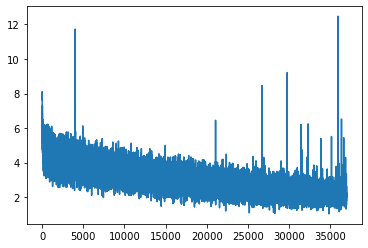

In [57]:
plt.plot(np.arange(len(train_trunc)), np.array(train_trunc))

In [70]:
merge_25 = MergeModel(summary_model, senti_model)
merge_25.load_state_dict(torch.load('BART_classifier_25_KL.pt'))

<All keys matched successfully>

In [73]:
merge_25.cuda()
merge_25.eval()

MergeModel(
  (summary_model): BartForConditionalGeneration(
    (model): BartModel(
      (shared): Embedding(50265, 768, padding_idx=1)
      (encoder): BartEncoder(
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): BartLearnedPositionalEmbedding(1026, 768, padding_idx=1)
        (layers): ModuleList(
          (0): BartEncoderLayer(
            (self_attn): BartAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (final_layer

In [98]:
b1,b2,b3,b4 = next(iter(train_dataloader)) 

In [99]:
idx = 0

In [100]:
article =  tokenizer.decode(b1[idx,:],skip_special_tokens=True, clean_up_tokenization_spaces=False)
article

'(CNN)Two passengers found dead on a cruise ship in Puerto Rico appear to have died in a murder-suicide, the cruise line said. Holland America Line said two guests were found dead inside their stateroom on the ms Ryndam at 11:30 a.m. Thursday. "The cabin was immediately secured, and the authorities were notified, including the FBI," Holland America said. "We are cooperating fully with the investigation, and the authorities will make the official determination on what occurred." FBI spokesman Moises Quiñones said authorities were on scene investigating. The ship left Tampa, Florida, on March 29 on a 14-day Southern Caribbean cruise. It\'s currently in San Juan, Puerto Rico. Puerto Rico Port Authority spokesman Efraín Santiago told El Nuevo Dia newspaper that the cleaning staff on the ship had discovered the deceased passengers after knocking on the cabin\'s door.'

In [101]:
summary, *t = merge_25(b1.cuda(), b2.cuda(), b3.cuda(), b4.cuda())

RuntimeError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 10.92 GiB total capacity; 10.04 GiB already allocated; 3.50 MiB free; 259.67 MiB cached)

In [102]:
summ = tokenizer.decode(summary.logits.argmax(dim = -1)[idx,:], skip_special_tokens=True, clean_up_tokenization_spaces=False)
summ

"Thesuit brought to block Encinitas Union School District from teaching yoga as\nFamily's lawsuit claimed yoga promoted Hinduism and inhibited Christianity .\nCaliforniath District court of Appeal ruled San Diego upheld court ruling . lawsuit .District saidhas yoga taught in secular way to promote flexibility flexibility and balance .Yoga taught at students's 5,600 students at twice-weekly, 30-minute classes .Ymanmanmanmanmanmanmanmanmanmanmanmanmanmanmanman"

# Testing

b1,b2,b3,b4 = next(iter(train_dataloader))
b1 = b1.cuda()
b2 = b2.cuda()
b3 = b3.cuda()
b4 = b4.cuda()

b1.shape, b2.shape, b3.shape, b4.shape

z1 = torch.nn.Parameter(torch.ones_like(b1).float()).long()
z2 = torch.ones_like(b2)

z1_dash = z1 + 5
z2_dash = z2 + 5

t = summary_model(b1, b2)

t.logits.shape

merge_model.train()

t_dash = merge_model(b1, b2, b3,b4)

t_dash[0].logits.shape

loss = mse_loss(t_dash[1], t_dash[2])

print(torch.autograd.grad(loss,merge_model.summary_model.parameters(), retain_graph=True))